### MPA_RF

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Saving into Log

In [8]:
import logging

# Setup basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("RF_optimization_PTB_XL.log"),  # Log to this file
                        logging.StreamHandler()  # Log to standard output
                    ])

### Determining necessary parameters

In [9]:
import numpy as np

# Example usage with the correct bounds for SVM:
search_agents_no = 30  # number of search agents
dim = 2  # number of dimensions / hyperparameters
Max_iter = 20  # Maximum number of iterations

# Bounds for 'max_depth' (discrete, integer)
max_depth_lb = 10
max_depth_ub = 105  # Assuming inclusive upper bound

# Bounds for 'n_estimators' (discrete, integer)
n_estimators_lb = 10
n_estimators_ub = 2000  # Assuming inclusive upper bound

# Create arrays of lower bounds (lb) and upper bounds (ub)
lb = np.array([n_estimators_lb, max_depth_lb])
ub = np.array([n_estimators_ub, max_depth_ub])


### Loading Training Dataset

In [10]:
import cudf
import pandas as pd
from cuml.ensemble import RandomForestClassifier as cumlRF
from cuml.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from cuml.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns


# Load and prepare data
train_data = cudf.read_csv('/home/jupyter-yangiev/MPA_int_ML/Train_new.csv')

features = [str(i) for i in range(187)] + [f'coeff{i}' for i in range(1, 221)] + ['SDNN', 'RMSSD', 'Mean_P_Wave_Duration', 'Mean_QRS_Duration', 'Mean_T_Wave_Duration', 'Mean_QT_Interval', 'Mean_PR_Interval']
labels = ['CD', 'HYP', 'MI', 'NORM', 'STTC']

# Split features and labels
X = train_data[features].astype('float32')  # Convert feature data to float32 for better performance
y = train_data[labels].astype('int32')  # Assuming target data are for classification and should be integers

# Convert to Pandas DataFrame for resampling
X_pd = X.to_pandas()
y_pd = y.to_pandas()

# Function to resample each label independently while aligning with the features
def resample_multilabel(X, y, labels):
    ros = RandomOverSampler(random_state=42)
    X_resampled = pd.DataFrame(X)  # Initialize X_resampled directly from the original X
    y_resampled = pd.DataFrame(index=X.index)  # Initialize y_resampled with the same index as X

    for label in labels:
        # Resample each label with the same features
        _, y_resampled[label] = ros.fit_resample(X, y[label])
        
    return X_resampled, y_resampled

# Apply resampling for multi-label data
X_resampled, y_resampled = resample_multilabel(X_pd, y_pd, labels)

# Convert back to cuDF DataFrames for further processing (if using cuML or other GPU-accelerated processes)
X_resampled = cudf.DataFrame.from_pandas(X_resampled)
y_resampled = cudf.DataFrame.from_pandas(y_resampled)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### Levy, Initialization, Fitness and Confusion Matrix Plot Functions

In [11]:
import math

# Levy function
def levy(search_agents_no, dim, beta=3/2):
    sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2)) / \
            (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2)) ** (1 / beta)
    u = np.random.randn(search_agents_no, dim) * sigma
    v = np.random.randn(search_agents_no, dim)
    step = u / (np.abs(v) ** (1 / beta))
    L = 0.05 * step  # Scale factor can be adjusted as needed
    return L

# Prey initialization function 
def initialization(search_agents_no, dim, ub, lb):
    if np.isscalar(lb) and np.isscalar(ub):
        # If the boundaries are both single numbers, apply them to all dimensions
        positions = np.random.rand(search_agents_no, dim) * (ub - lb) + lb
    else:
        # If the boundaries are arrays with different values for each dimension
        positions = np.zeros((search_agents_no, dim))
        for i in range(dim):
            ub_i = ub[i]
            lb_i = lb[i]
            positions[:, i] = np.random.rand(search_agents_no) * (ub_i - lb_i) + lb_i
    return positions

# Objective fitness function
def rf_accuracy_fitness(X_params, X_train, y_train, X_val, y_val):
    
    print("X_params shape:", X_params.shape)
    n_estimators, max_depth = int(round(X_params[0][0])), int(round(X_params[0][1]))
    print("n_estimators:", n_estimators, "max_depth:", max_depth)
    
    fitness_list = []
    conf_matrices = []
    
    for idx, label in enumerate(labels):
        model = cumlRF(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_streams=1)
        model.fit(X_train, y_train[label])
        
        preds = model.predict(X_val).astype('int32')
        accuracy = accuracy_score(y_val[label], preds)
        fitness_list.append(accuracy)
        
        # Here, we cast to integers to make sure the data type is correct for confusion_matrix
        true_labels = y_val[label].astype('int32').values
        pred_labels = preds.astype('int32').values
        conf_matrix = confusion_matrix(true_labels, pred_labels)
        
        conf_matrices.append(conf_matrix)

    fitness = np.mean(fitness_list)

    return fitness, conf_matrices



# Plot Confusion matrix function

def plot_confusion_matrix(conf_matrices, labels, individual_index):
    num_labels = len(labels)
    fig, axes = plt.subplots(1, num_labels, figsize=(15, 5), sharey=True)  # Adjust the figure size as necessary

    if num_labels == 1:  # If there's only one label, wrap axes in a list
        axes = [axes]

    for idx, (label, conf_matrix) in enumerate(zip(labels, conf_matrices)):
        ax = axes[idx]
        # Ensure the confusion matrix is in NumPy format
        if hasattr(conf_matrix, 'get'):  # Check if 'get' method exists, indicating a CuPy array
            conf_matrix = conf_matrix.get()  # Convert to NumPy array
        
        # Calculate percentage
        row_sums = conf_matrix.sum(axis=1, keepdims=True)
        percentage_matrix = 100 * conf_matrix / row_sums
        
        sns.heatmap(percentage_matrix, annot=True, fmt=".2f", cmap="Blues", ax=ax, cbar=True)
        ax.set_title(label)  # Set the title to just the label name
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_xticklabels(['False', 'True'])  # Assuming binary classification
        ax.set_yticklabels(['False', 'True'])

    # Set a title for the entire figure
    fig.suptitle(f"Confusion Matrix for Individual {individual_index}", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for figure-wide title
    plt.show()


def get_model_from_params(params):
    n_estimators, max_depth = round(params[0]), round(params[1])
    model = cumlRF(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42, n_streams=1)
    return model
    

### Define MPA function

In [12]:
import pickle

def MPA(search_agents_no, Max_iter, lb, ub, dim, X_train, y_train, X_val, y_val, rf_accuracy_fitness, fitness_threshold=0.90):
   
    Top_predator_pos = np.zeros(dim)
    Top_predator_fit = -np.inf  # Start with the lowest possible value
    best_model = None  # Variable to store the best model
    stepsize = np.zeros((search_agents_no, dim))
    fitness = np.full(search_agents_no, -np.inf)
     
    Prey = initialization(search_agents_no, dim, ub, lb)
    model_path = 'best_model_mpa_RF_ptb_xl.pkl'  # Define the path where the model will be saved
    
    Xmin = np.tile(lb, (search_agents_no, 1))
    Xmax = np.tile(ub, (search_agents_no, 1))

    best_fitness_values = []  # Keep track of the best fitness value at each iteration
    average_fitness_values = []  # Keep track of the average fitness value
    
    Iter = 0
    FADs = 0.2
    P = 0.5

    for Iter in range(Max_iter):
        # Detecting Top predator
        for i in range(search_agents_no):
            Flag4ub = Prey[i, :] > ub
            Flag4lb = Prey[i, :] < lb
            Prey[i, :] = Prey[i, :] * (~(Flag4ub | Flag4lb)) + ub * Flag4ub + lb * Flag4lb
            logging.info(f"Calculating fitness for individual {i+1}/{search_agents_no}")
            fitness[i], conf_matrices = rf_accuracy_fitness(Prey[[i], :], X_train, y_train, X_val, y_val)
           
            logging.info(f"Fitness for individual {i+1}: {fitness[i]}")
            # Plot the confusion matrix for the current individual
            plot_confusion_matrix(conf_matrices, labels, i+1)  # Passing i+1 as the individual index
            
            if fitness[i] > Top_predator_fit:
                Top_predator_fit = fitness[i]
                Top_predator_pos = Prey[i, :].copy()
                best_model = get_model_from_params(Top_predator_pos)  # Assuming you have a function to create a model from params
                
        # Marine memory saving
        if Iter == 0:
            fit_old = fitness.copy()
            Prey_old = Prey.copy()
        
        # For maximization: Check if the current fitness is greater than the old fitness
        Inx = fitness > fit_old
        Indx = np.tile(Inx[:, None], (1, dim))
        
        # Update positions: Use the newer positions if the current fitness is better; otherwise, revert to old positions
        Prey = Indx * Prey + (~Indx) * Prey_old
        
        # Update fitness: Keep the higher current fitness values; otherwise, revert to old fitness values
        fitness = np.where(Inx, fitness, fit_old)
        
        fit_old = fitness.copy()  # Prepare for the next iteration
        Prey_old = Prey.copy()

        # --------------------////------------------
        Elite = np.tile(Top_predator_pos, (search_agents_no, 1))  # Construct Elite Matrix
        CF = (1 - Iter / Max_iter) ** (2 * Iter / Max_iter)

        RL = 0.05 * levy(search_agents_no, dim, 1.5)    # Levy random number vector
        RB = np.random.randn(search_agents_no, dim)     # Brownian random number vector

        for i in range(search_agents_no):
            for j in range(dim):
                R = np.random.rand()
                # Phase 1
                if Iter < Max_iter / 3:
                    stepsize[i, j] = RB[i, j] * (Elite[i, j] - RB[i, j] * Prey[i, j])
                    Prey[i, j] = Prey[i, j] + P * R * stepsize[i, j]
                # Phase 2
                elif Max_iter / 3 < Iter < 2 * Max_iter / 3:
                    if i > search_agents_no / 2:
                        stepsize[i, j] = RB[i, j] * (RB[i, j] * Elite[i, j] - Prey[i, j])
                        Prey[i, j] = Elite[i, j] + P * CF * stepsize[i, j]
                    else:
                        stepsize[i, j] = RL[i, j] * (Elite[i, j] - RL[i, j] * Prey[i, j])
                        Prey[i, j] = Prey[i, j] + P * R * stepsize[i, j]
                # Phase 3
                else:
                    stepsize[i, j] = RL[i, j] * (RL[i, j] * Elite[i, j] - Prey[i, j])
                    Prey[i, j] = Elite[i, j] + P * CF * stepsize[i, j]
                # ------------------ Detecting top predator ------------------  
        for i in range(search_agents_no):
            # Enforce boundary conditions
            Flag4ub = Prey[i, :] > ub
            Flag4lb = Prey[i, :] < lb
            Prey[i, :] = (Prey[i, :] * (~(Flag4ub | Flag4lb))) + ub * Flag4ub + lb * Flag4lb
            logging.info(f"Calculating fitness for individual after 3 Phases {i+1}/{search_agents_no}")
            # Evaluate fitness
            fitness[i], conf_matrices = rf_accuracy_fitness(Prey[[i], :], X_train, y_train, X_val, y_val)
           
            logging.info(f"Fitness for individual {i+1}: {fitness[i]}")
            # Plot the confusion matrix for the current individual
            plot_confusion_matrix(conf_matrices, labels, i+1)  # Passing i+1 as the individual index
            
            # Update top predator if current solution is better (for maximization)
            if fitness[i] > Top_predator_fit:
                Top_predator_fit = fitness[i]
                Top_predator_pos = Prey[i, :].copy()
                best_model = get_model_from_params(Top_predator_pos)  # Assuming you have a function to create a model from params
                
        # Marine memory saving  --------///-----------
        if Iter == 0:
            fit_old = fitness.copy()
            Prey_old = Prey.copy()
        
        Inx = fitness > fit_old  # For maximization: keep if current fitness is better
        Indx = np.tile(Inx[:, None], (1, dim))
        Prey = Indx * Prey + (~Indx) * Prey_old  # Update positions based on better fitness
        fitness = np.where(Inx, fitness, fit_old)  # Update fitness values accordingly
        
        fit_old = fitness.copy()  # Update old fitness for the next iteration
        Prey_old = Prey.copy()  # Update old positions for the next iteration
        
        
        # Eddy formation and FADs’ effect
        if np.random.rand() < FADs:
            U = np.random.rand(search_agents_no, dim) < FADs
            Prey = Prey + CF * ((Xmin + np.random.rand(search_agents_no, dim) * (Xmax - Xmin)) * U)
        else:
            r = np.random.rand()
            Rs = Prey.shape[0]
            stepsize = (FADs * (1 - r) + r) * (Prey[np.random.permutation(Rs), :] - Prey[np.random.permutation(Rs), :])
            Prey = Prey + stepsize

        current_best_fitness = Top_predator_fit
        best_fitness_values.append(current_best_fitness)
        
        # Calculate average fitness of the population
        current_avg_fitness = np.mean(fitness)
        average_fitness_values.append(current_avg_fitness)
        
        # Log the metrics
        logging.info(f"Iteration: {Iter+1}/{Max_iter}, Best Fitness: {current_best_fitness}, Average Fitness: {current_avg_fitness}")
        
        if Top_predator_fit >= fitness_threshold:
            logging.info(f"Fitness threshold reached: {Top_predator_fit} at iteration {Iter+1}. Terminating...")
            with open(model_path, 'wb') as f:
                pickle.dump(best_model, f)  # Save the best model
            logging.info(f"Model saved to {model_path} with fitness {Top_predator_fit} at iteration {Iter+1}")
            break  # Exit the loop if fitness threshold is reached
        
        # Update iteration counter and convergence curve
        Iter += 1

    return Top_predator_pos, Top_predator_fit


### Call MPA

2024-04-16 05:55:52,362 - INFO - Calculating fitness for individual 1/30


X_params shape: (1, 2)
n_estimators: 1168 max_depth: 42


2024-04-16 05:58:38,917 - INFO - Fitness for individual 1: 0.9099895238876343


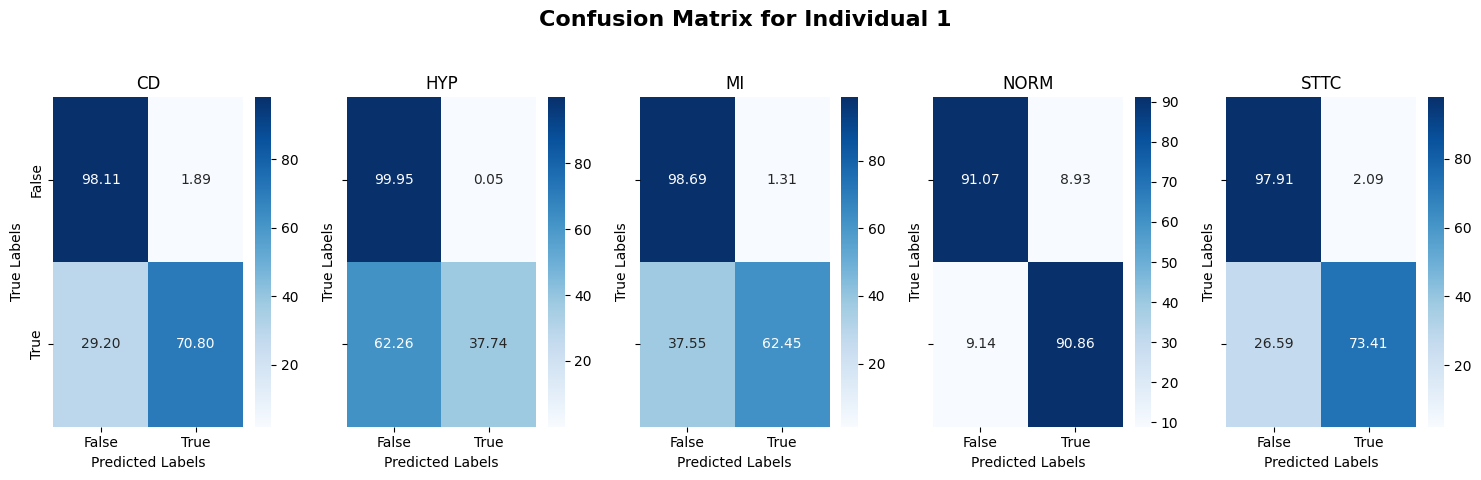

2024-04-16 05:58:41,237 - INFO - Calculating fitness for individual 2/30


X_params shape: (1, 2)
n_estimators: 1783 max_depth: 62


2024-04-16 06:02:44,199 - INFO - Fitness for individual 2: 0.9100916981697083


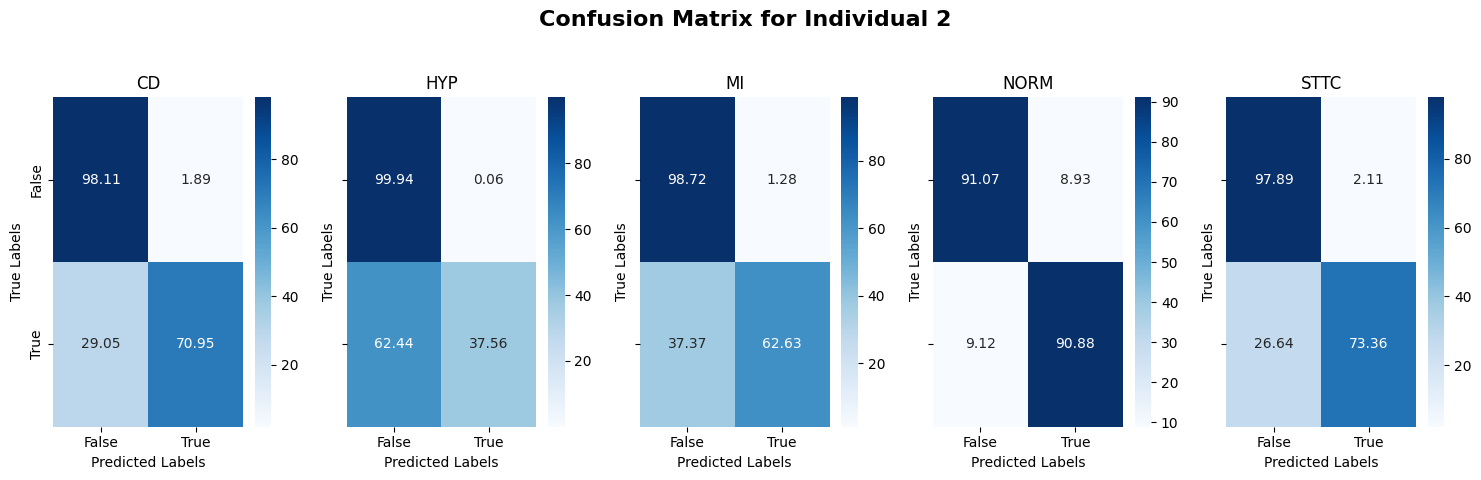

2024-04-16 06:02:46,303 - INFO - Calculating fitness for individual 3/30


X_params shape: (1, 2)
n_estimators: 1295 max_depth: 15


2024-04-16 06:04:27,643 - INFO - Fitness for individual 3: 0.8785216331481933


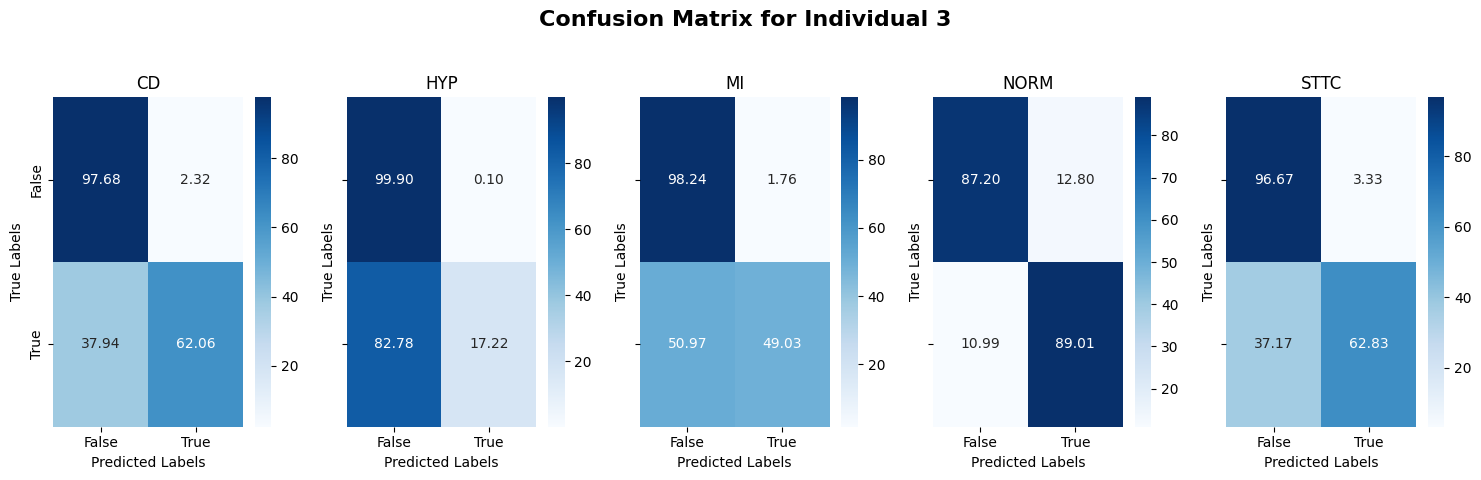

2024-04-16 06:04:29,545 - INFO - Calculating fitness for individual 4/30


X_params shape: (1, 2)
n_estimators: 706 max_depth: 96


2024-04-16 06:05:59,609 - INFO - Fitness for individual 4: 0.9099282264709473


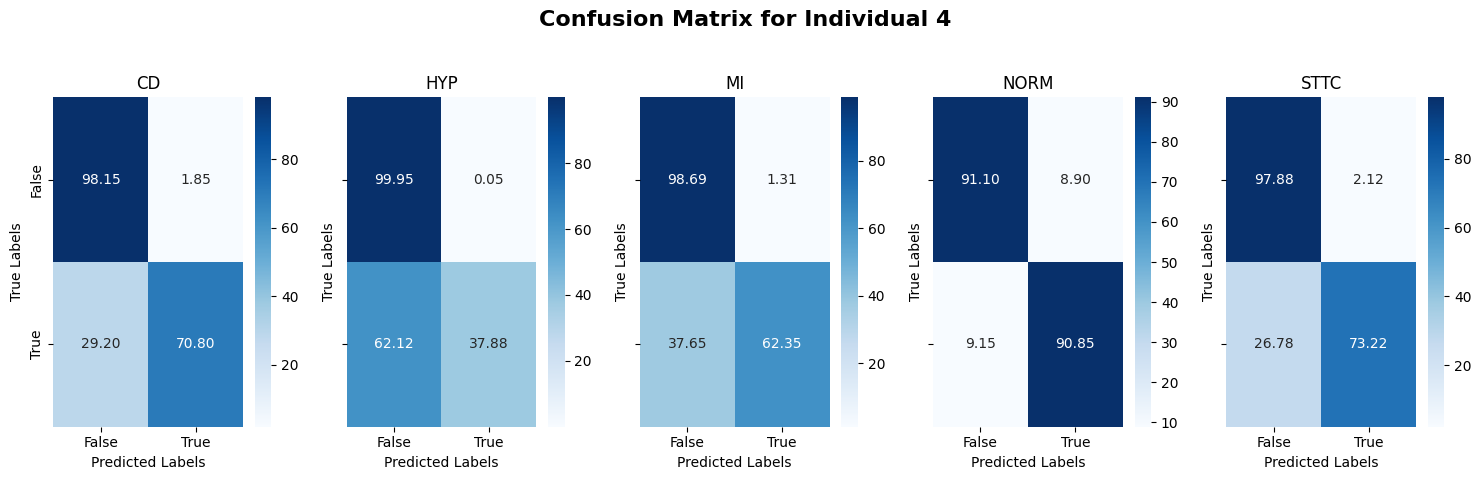

2024-04-16 06:06:01,521 - INFO - Calculating fitness for individual 5/30


X_params shape: (1, 2)
n_estimators: 1139 max_depth: 59


2024-04-16 06:08:28,124 - INFO - Fitness for individual 5: 0.91011723279953


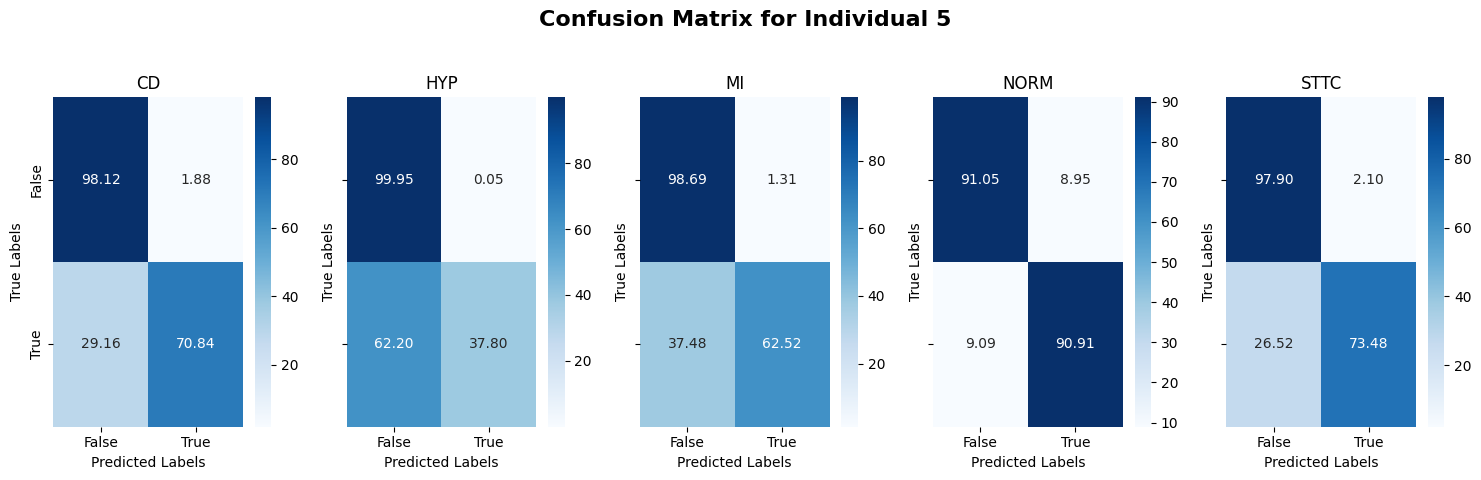

2024-04-16 06:08:30,013 - INFO - Calculating fitness for individual 6/30


X_params shape: (1, 2)
n_estimators: 1368 max_depth: 37


2024-04-16 06:11:23,110 - INFO - Fitness for individual 6: 0.9099895358085632


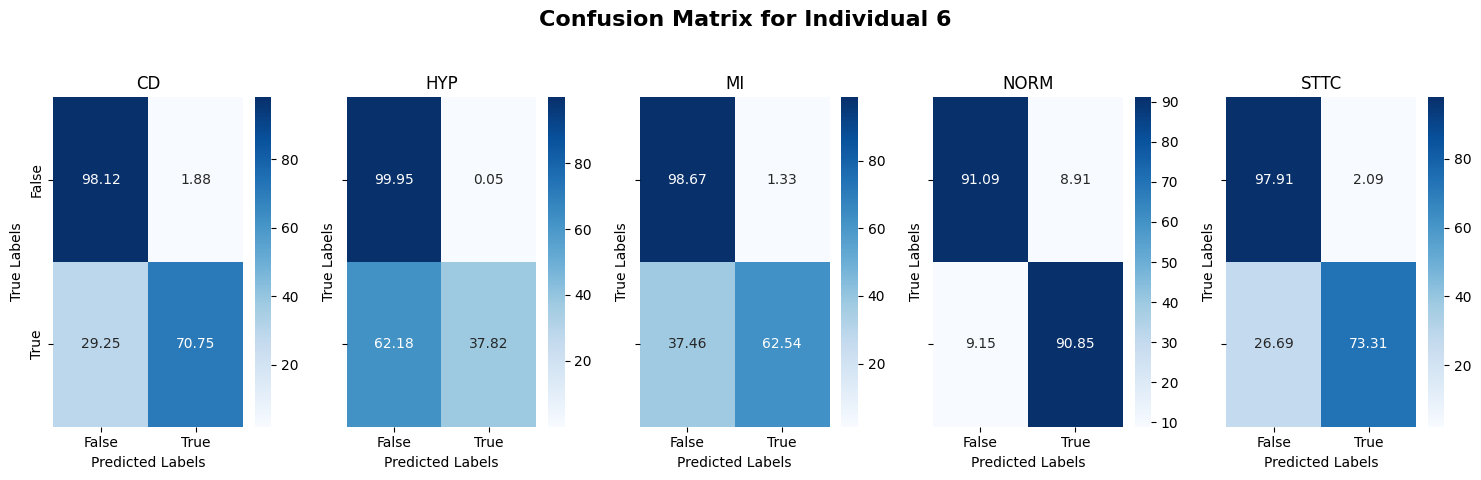

2024-04-16 06:11:25,294 - INFO - Calculating fitness for individual 7/30


X_params shape: (1, 2)
n_estimators: 788 max_depth: 64


2024-04-16 06:13:12,939 - INFO - Fitness for individual 7: 0.9098260521888732


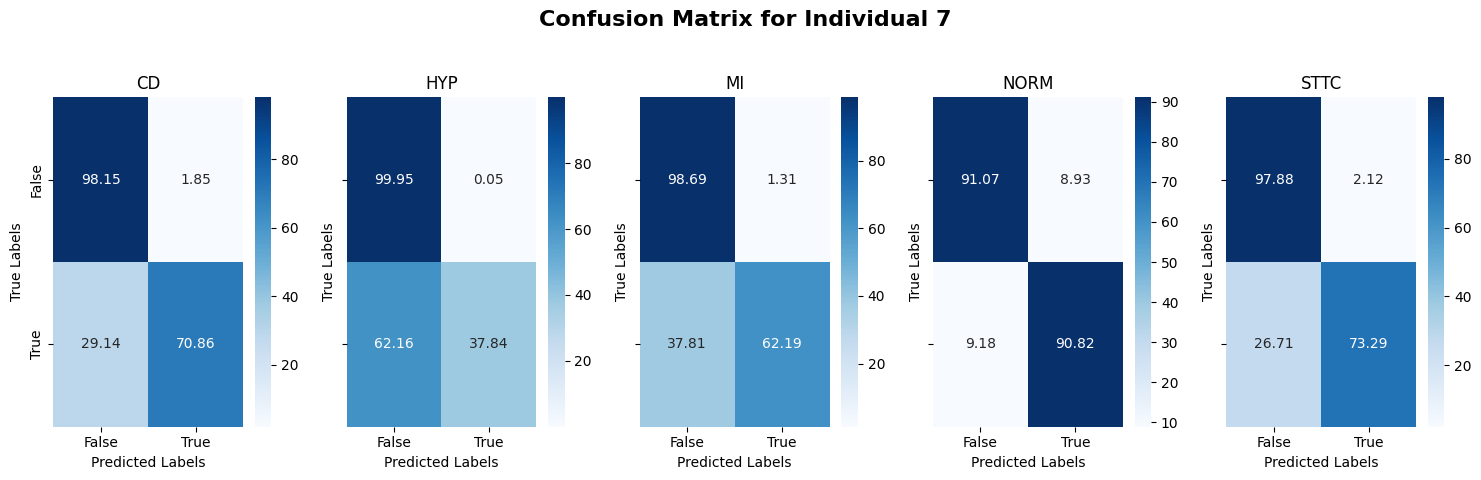

2024-04-16 06:13:14,848 - INFO - Calculating fitness for individual 8/30


X_params shape: (1, 2)
n_estimators: 272 max_depth: 20


2024-04-16 06:13:43,581 - INFO - Fitness for individual 8: 0.8989451050758361


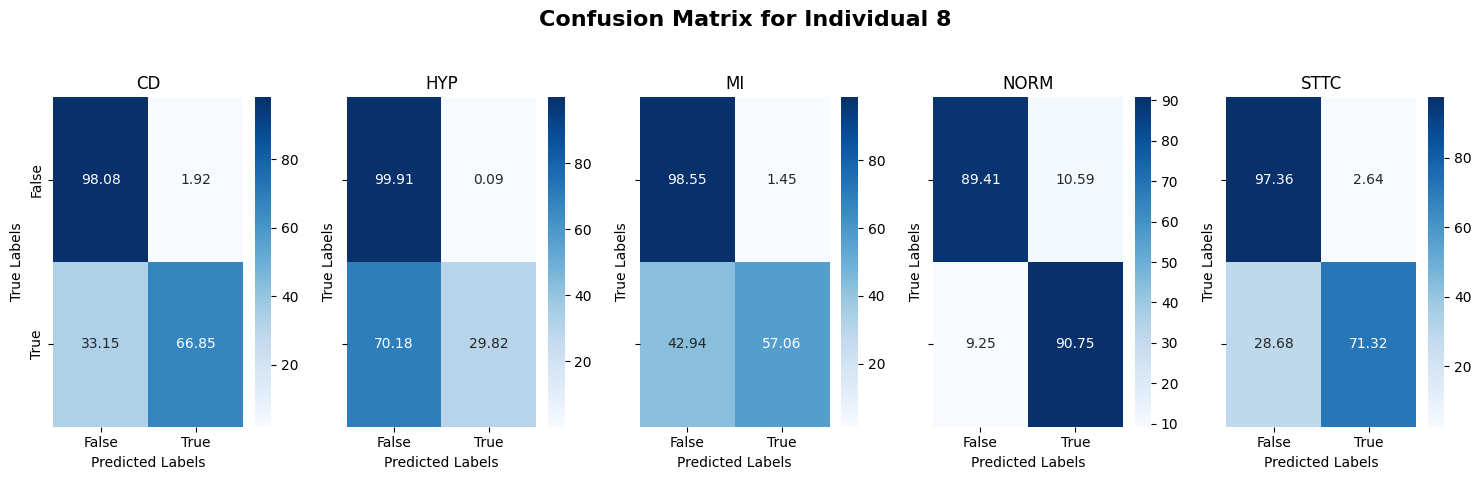

2024-04-16 06:13:45,459 - INFO - Calculating fitness for individual 9/30


X_params shape: (1, 2)
n_estimators: 1717 max_depth: 31


2024-04-16 06:17:08,661 - INFO - Fitness for individual 9: 0.9094582557678222


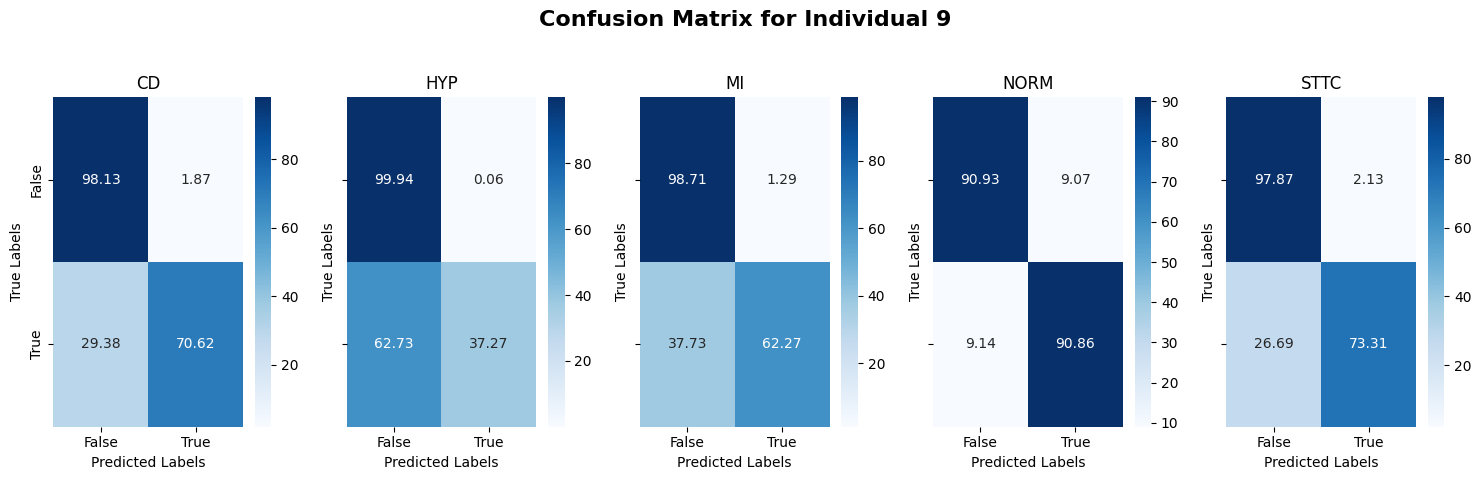

2024-04-16 06:17:10,618 - INFO - Calculating fitness for individual 10/30


X_params shape: (1, 2)
n_estimators: 318 max_depth: 57


2024-04-16 06:17:51,072 - INFO - Fitness for individual 10: 0.9091875076293945


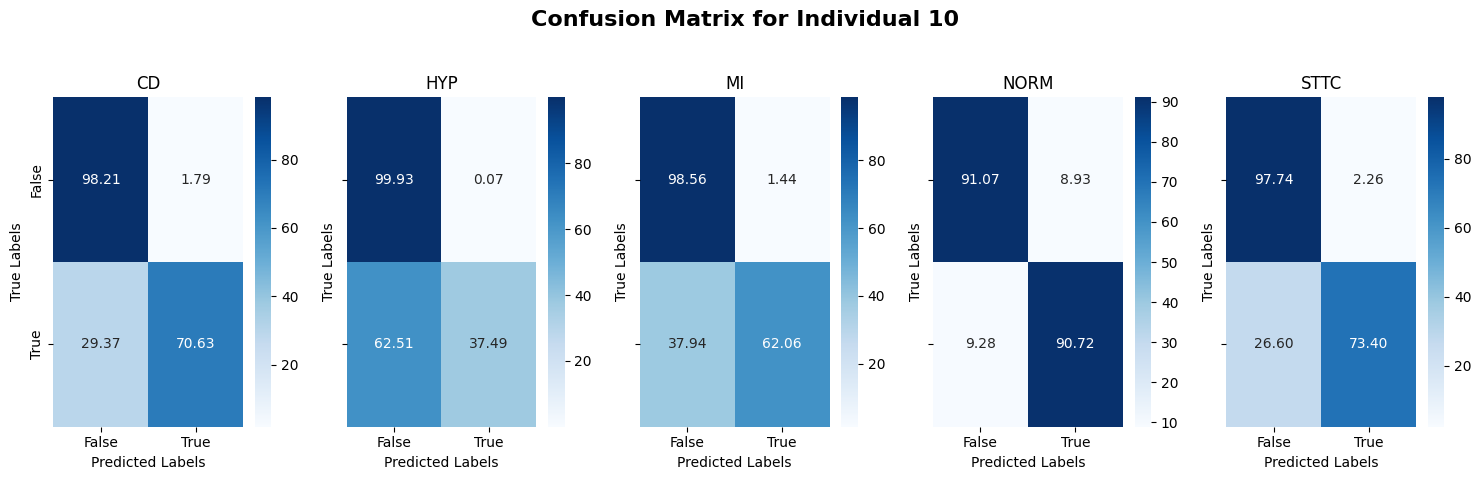

2024-04-16 06:17:52,937 - INFO - Calculating fitness for individual 11/30


X_params shape: (1, 2)
n_estimators: 39 max_depth: 89


2024-04-16 06:17:58,911 - INFO - Fitness for individual 11: 0.9054430246353149


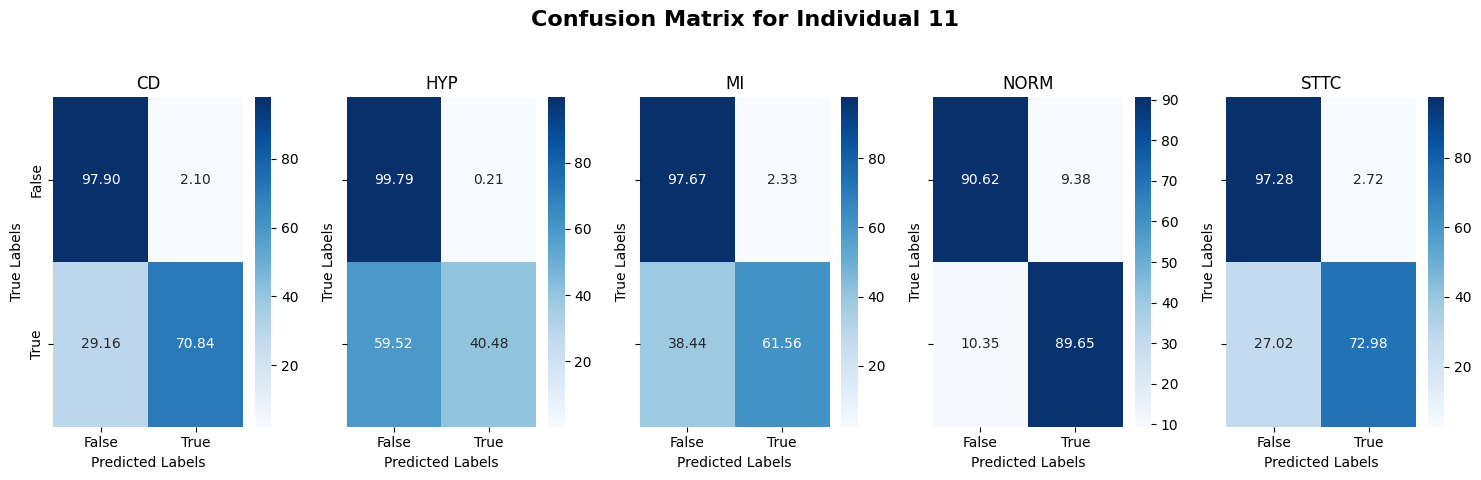

2024-04-16 06:18:00,929 - INFO - Calculating fitness for individual 12/30


X_params shape: (1, 2)
n_estimators: 1968 max_depth: 81


2024-04-16 06:22:32,957 - INFO - Fitness for individual 12: 0.9100099563598633


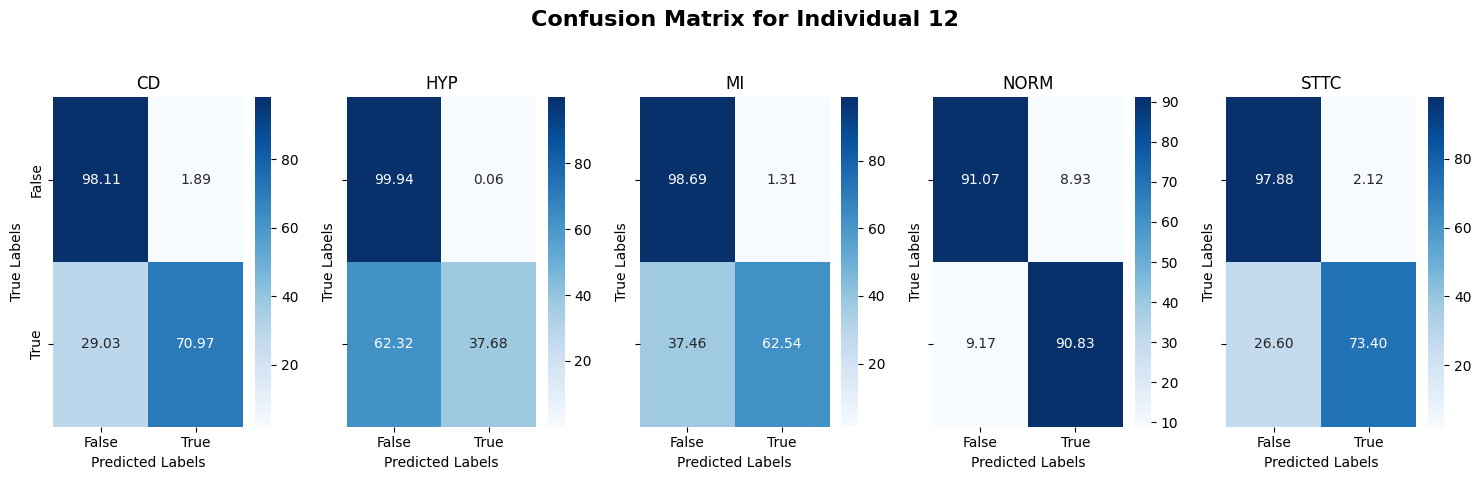

2024-04-16 06:22:34,827 - INFO - Calculating fitness for individual 13/30


X_params shape: (1, 2)
n_estimators: 1189 max_depth: 66


2024-04-16 06:25:14,347 - INFO - Fitness for individual 13: 0.9100661516189575


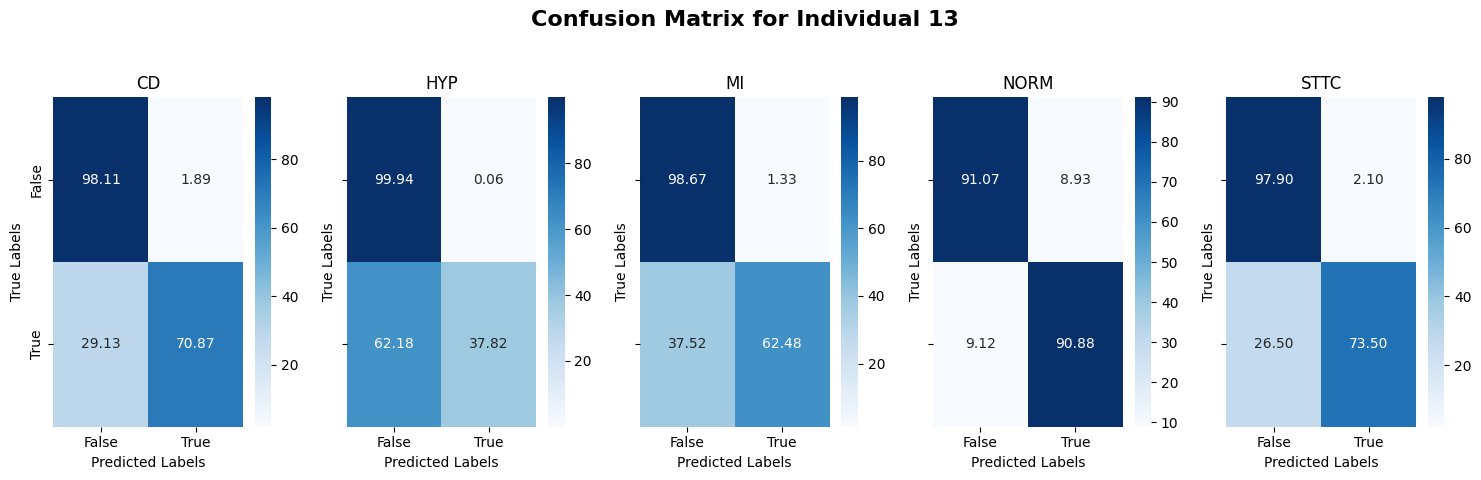

2024-04-16 06:25:16,290 - INFO - Calculating fitness for individual 14/30


X_params shape: (1, 2)
n_estimators: 575 max_depth: 95


2024-04-16 06:26:28,325 - INFO - Fitness for individual 14: 0.9098158359527588


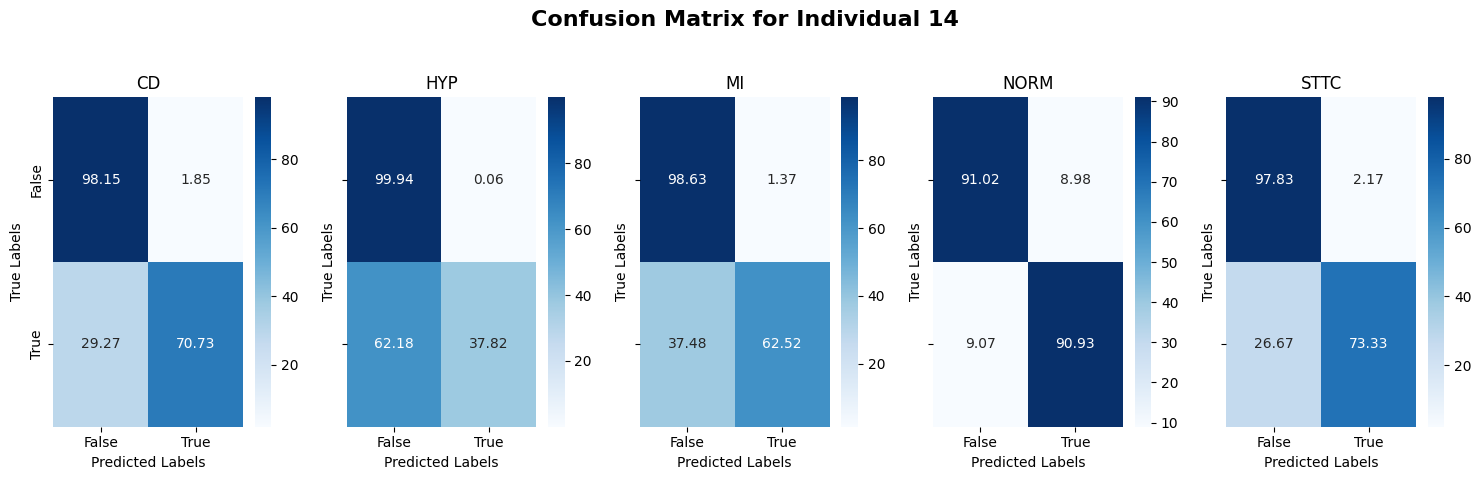

2024-04-16 06:26:30,205 - INFO - Calculating fitness for individual 15/30


X_params shape: (1, 2)
n_estimators: 1667 max_depth: 51


2024-04-16 06:30:11,705 - INFO - Fitness for individual 15: 0.910117244720459


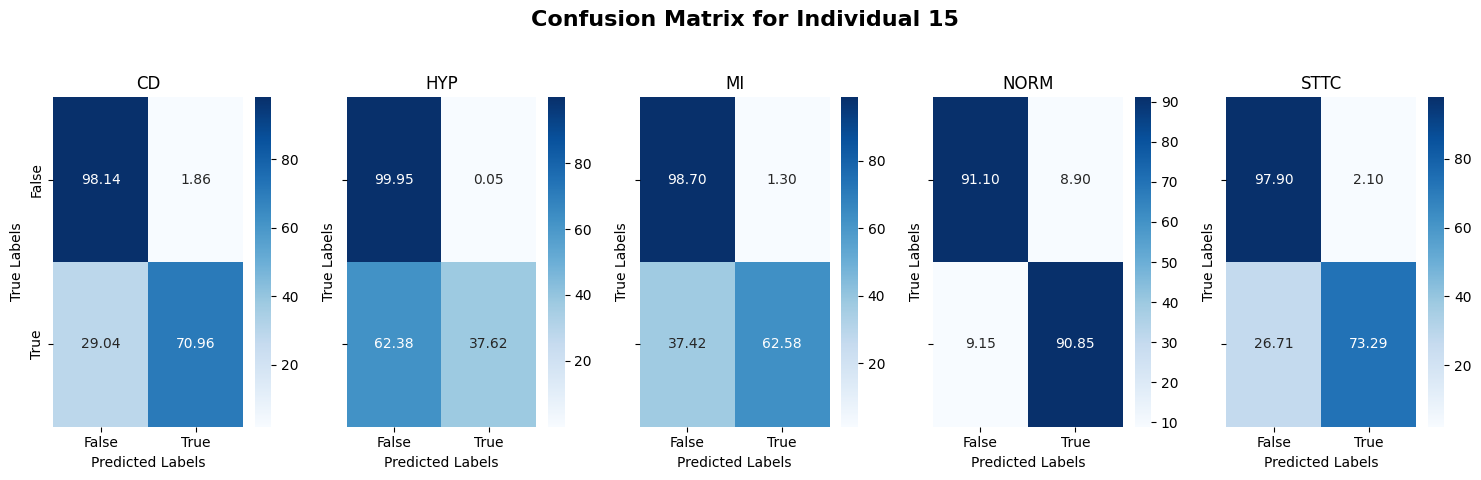

2024-04-16 06:30:13,816 - INFO - Calculating fitness for individual 16/30


X_params shape: (1, 2)
n_estimators: 1783 max_depth: 63


2024-04-16 06:34:16,892 - INFO - Fitness for individual 16: 0.9100916981697083


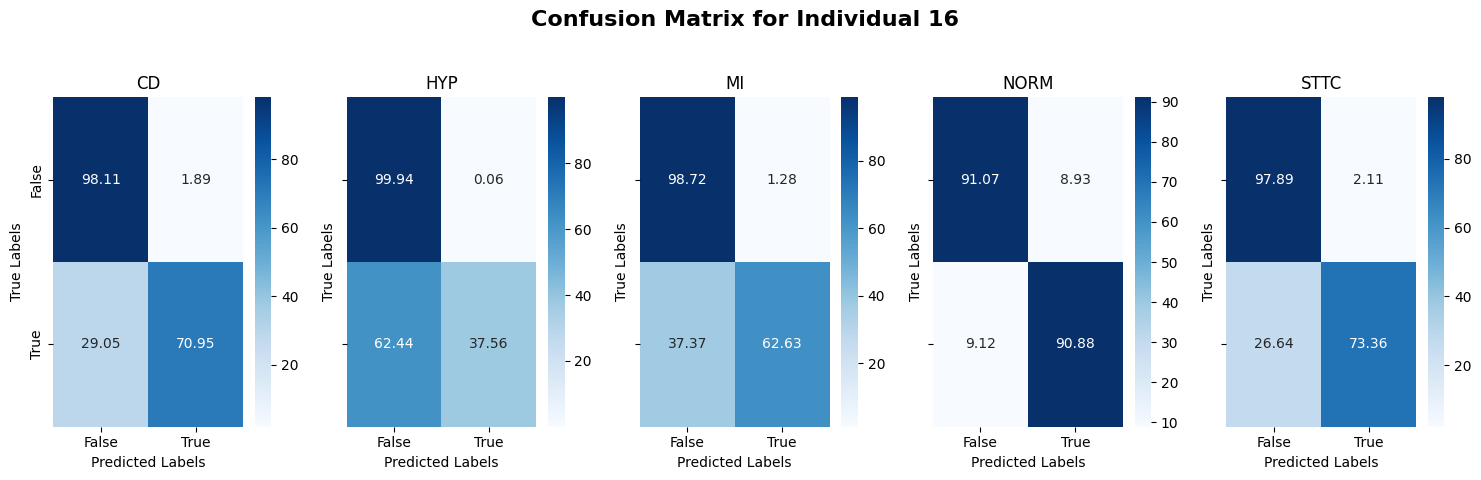

2024-04-16 06:34:19,058 - INFO - Calculating fitness for individual 17/30


X_params shape: (1, 2)
n_estimators: 691 max_depth: 48


2024-04-16 06:35:54,230 - INFO - Fitness for individual 17: 0.910015070438385


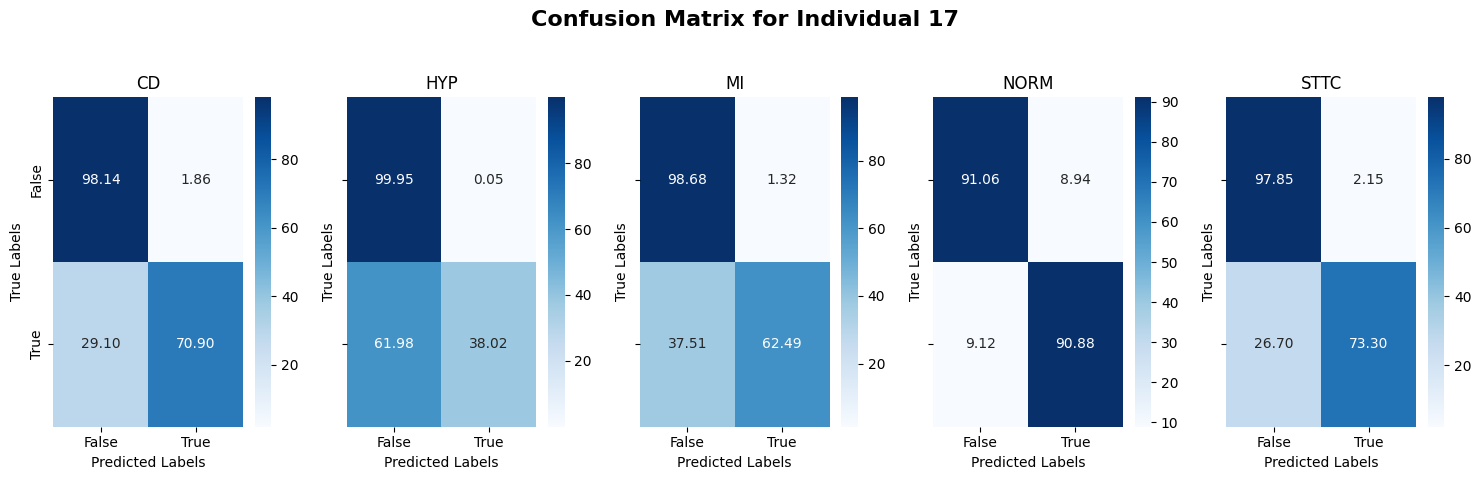

2024-04-16 06:35:56,098 - INFO - Calculating fitness for individual 18/30


X_params shape: (1, 2)
n_estimators: 681 max_depth: 47


2024-04-16 06:37:28,845 - INFO - Fitness for individual 18: 0.90993332862854


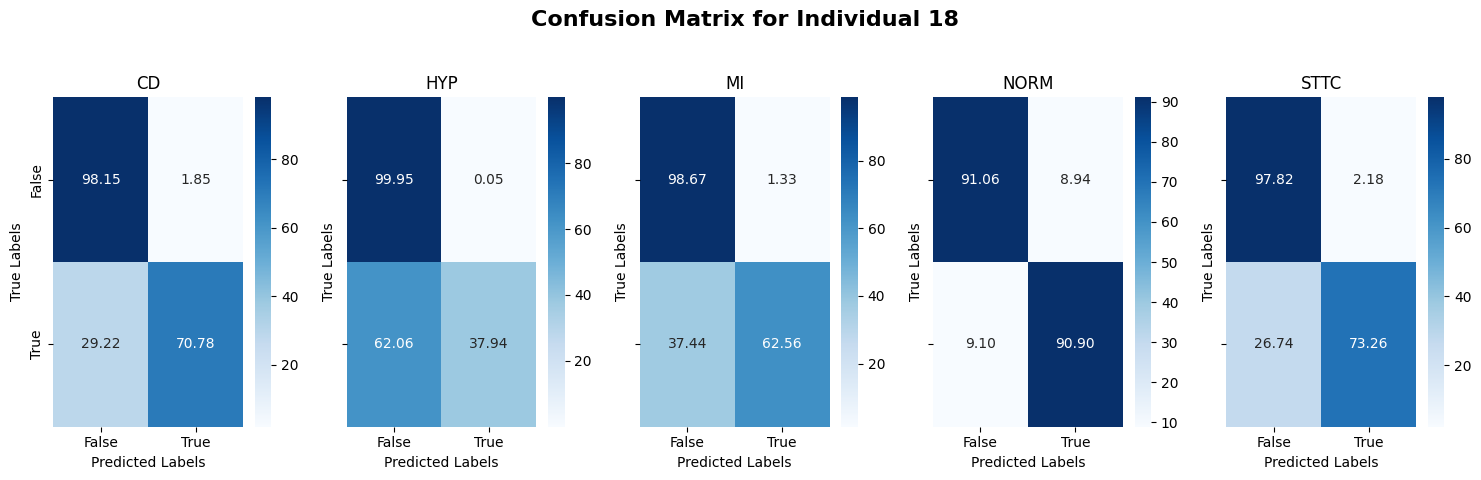

2024-04-16 06:37:30,713 - INFO - Calculating fitness for individual 19/30


X_params shape: (1, 2)
n_estimators: 189 max_depth: 82


2024-04-16 06:37:57,890 - INFO - Fitness for individual 19: 0.9089167594909668


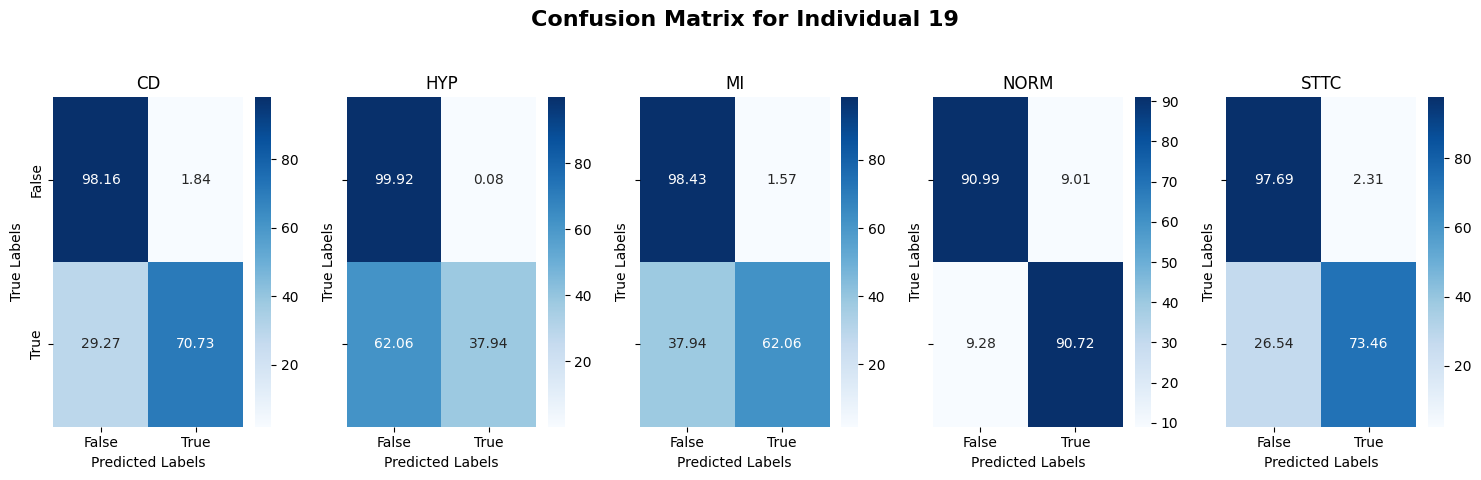

2024-04-16 06:37:59,797 - INFO - Calculating fitness for individual 20/30


X_params shape: (1, 2)
n_estimators: 1647 max_depth: 43


2024-04-16 06:41:42,136 - INFO - Fitness for individual 20: 0.9100763678550721


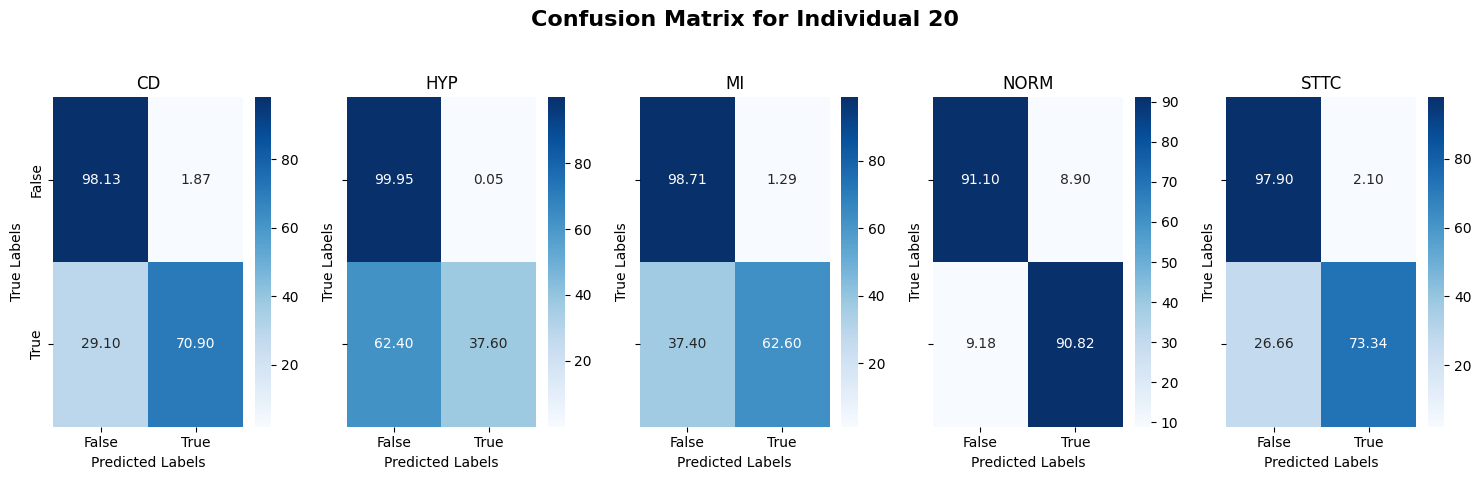

2024-04-16 06:41:44,033 - INFO - Calculating fitness for individual 21/30


X_params shape: (1, 2)
n_estimators: 1753 max_depth: 88


2024-04-16 06:45:44,417 - INFO - Fitness for individual 21: 0.9100303888320923


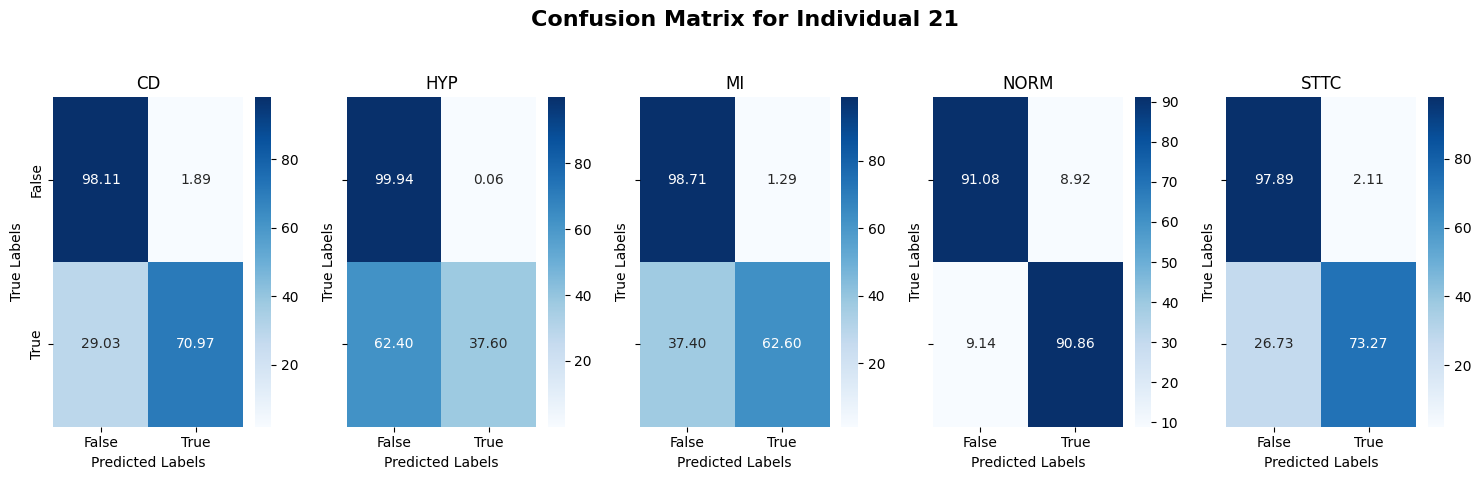

2024-04-16 06:45:46,658 - INFO - Calculating fitness for individual 22/30


X_params shape: (1, 2)
n_estimators: 873 max_depth: 95


2024-04-16 06:47:48,201 - INFO - Fitness for individual 22: 0.9101734280586242


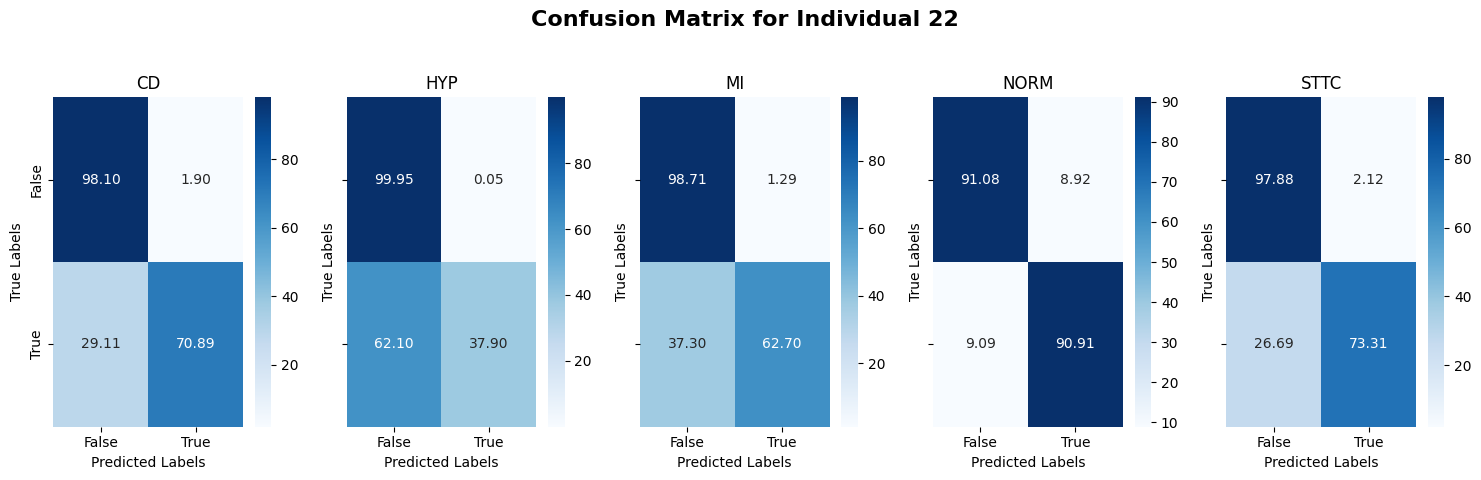

2024-04-16 06:47:50,069 - INFO - Calculating fitness for individual 23/30


X_params shape: (1, 2)
n_estimators: 280 max_depth: 66


2024-04-16 06:48:30,098 - INFO - Fitness for individual 23: 0.9090904355049133


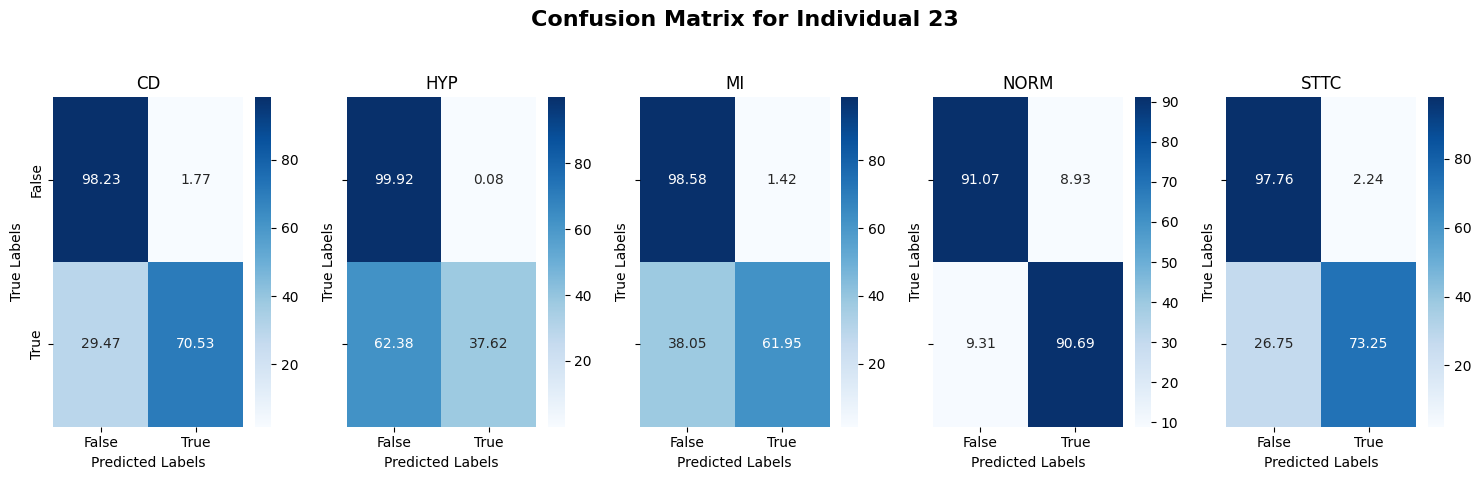

2024-04-16 06:48:32,005 - INFO - Calculating fitness for individual 24/30


X_params shape: (1, 2)
n_estimators: 1513 max_depth: 82


2024-04-16 06:52:02,087 - INFO - Fitness for individual 24: 0.910076355934143


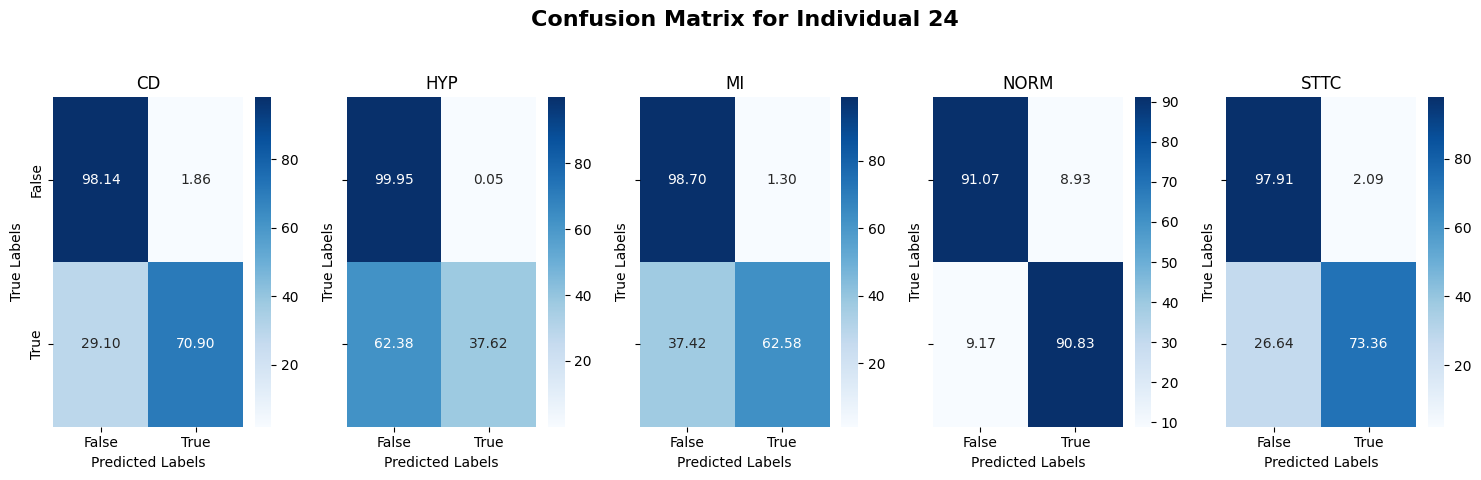

2024-04-16 06:52:04,255 - INFO - Calculating fitness for individual 25/30


X_params shape: (1, 2)
n_estimators: 933 max_depth: 48


2024-04-16 06:54:13,678 - INFO - Fitness for individual 25: 0.9100610494613648


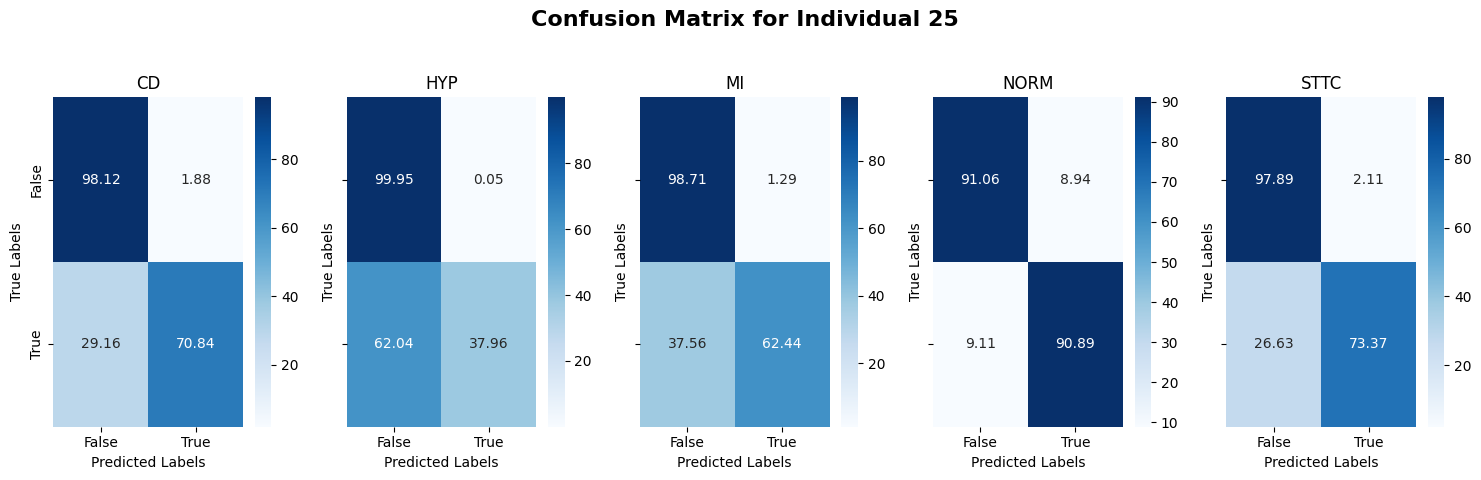

2024-04-16 06:54:15,557 - INFO - Calculating fitness for individual 26/30


X_params shape: (1, 2)
n_estimators: 1303 max_depth: 71


2024-04-16 06:57:17,270 - INFO - Fitness for individual 26: 0.9100712656974792


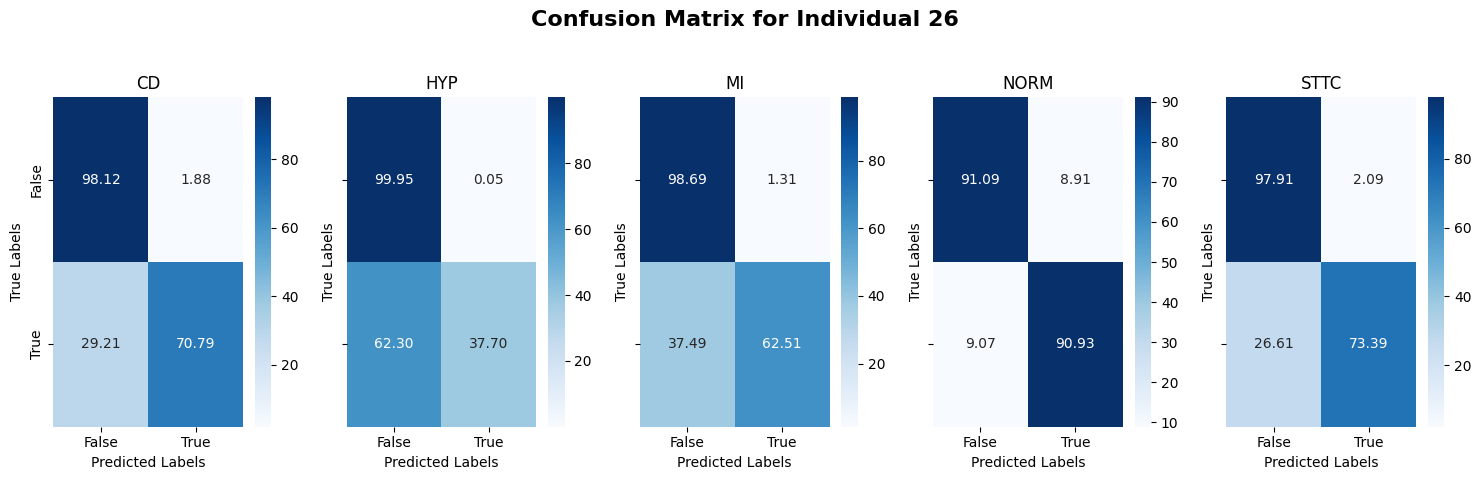

2024-04-16 06:57:19,714 - INFO - Calculating fitness for individual 27/30


X_params shape: (1, 2)
n_estimators: 1993 max_depth: 74


2024-04-16 07:01:58,114 - INFO - Fitness for individual 27: 0.9100865960121155


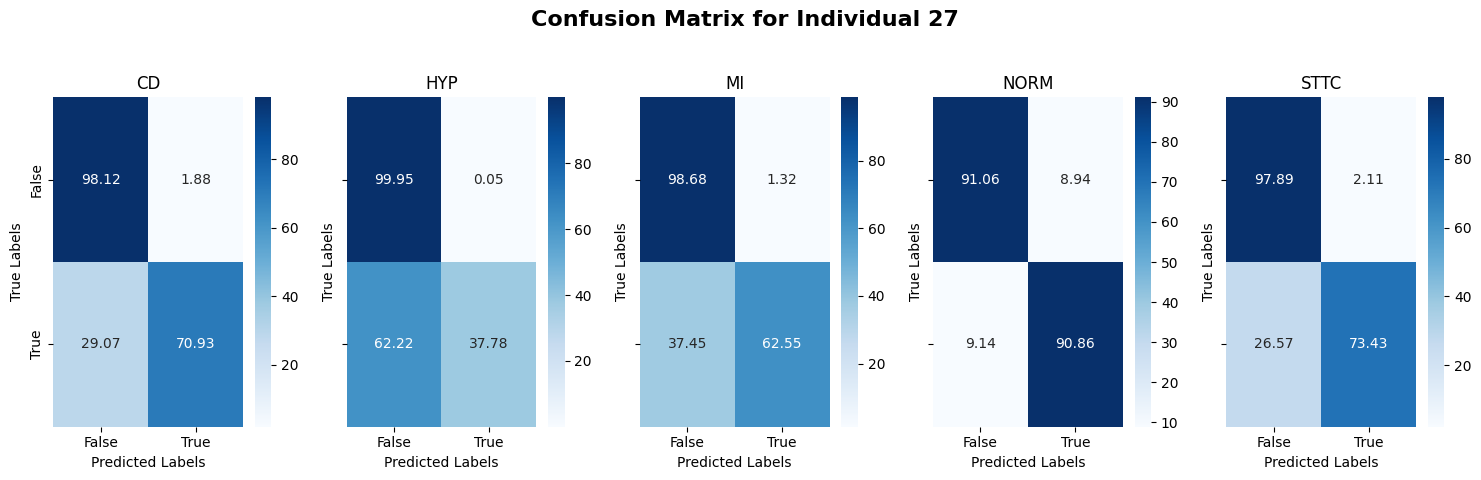

2024-04-16 07:02:00,085 - INFO - Calculating fitness for individual 28/30


X_params shape: (1, 2)
n_estimators: 1995 max_depth: 88


2024-04-16 07:06:39,904 - INFO - Fitness for individual 28: 0.9101019144058228


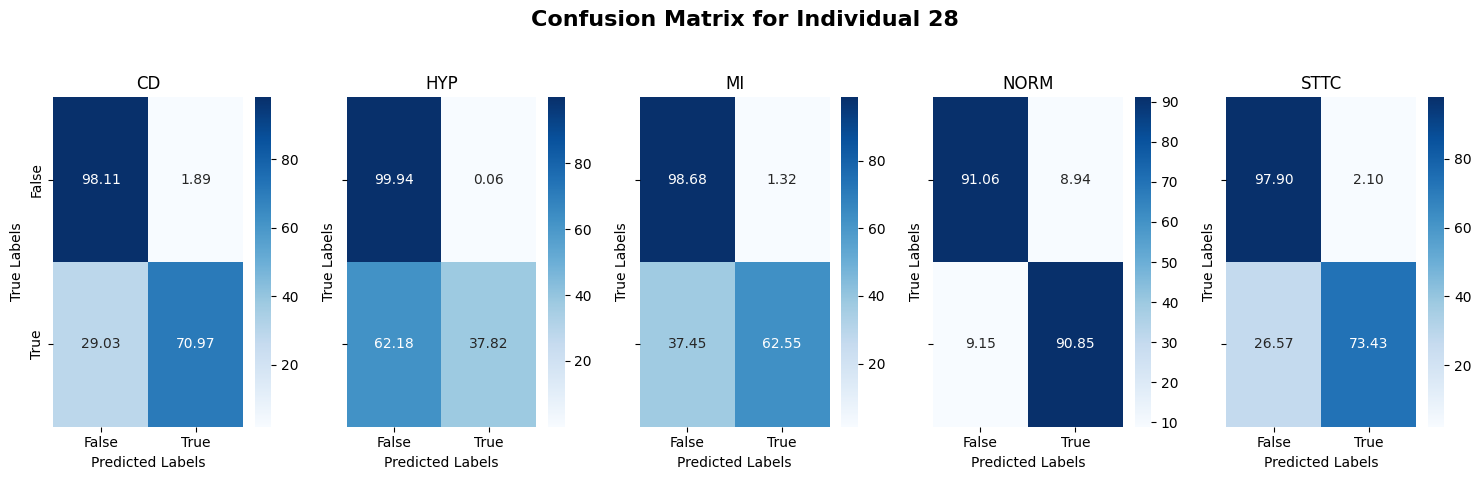

2024-04-16 07:06:41,821 - INFO - Calculating fitness for individual 29/30


X_params shape: (1, 2)
n_estimators: 495 max_depth: 28


2024-04-16 07:07:45,680 - INFO - Fitness for individual 29: 0.9082679986953736


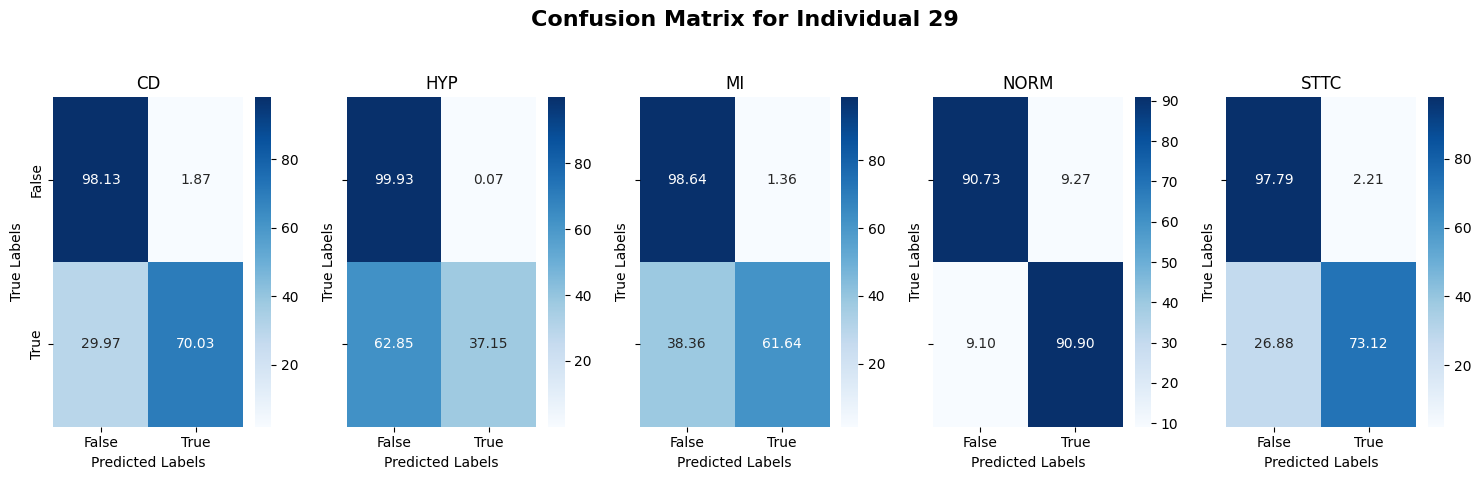

2024-04-16 07:07:47,549 - INFO - Calculating fitness for individual 30/30


X_params shape: (1, 2)
n_estimators: 699 max_depth: 65


2024-04-16 07:09:25,278 - INFO - Fitness for individual 30: 0.9100048542022705


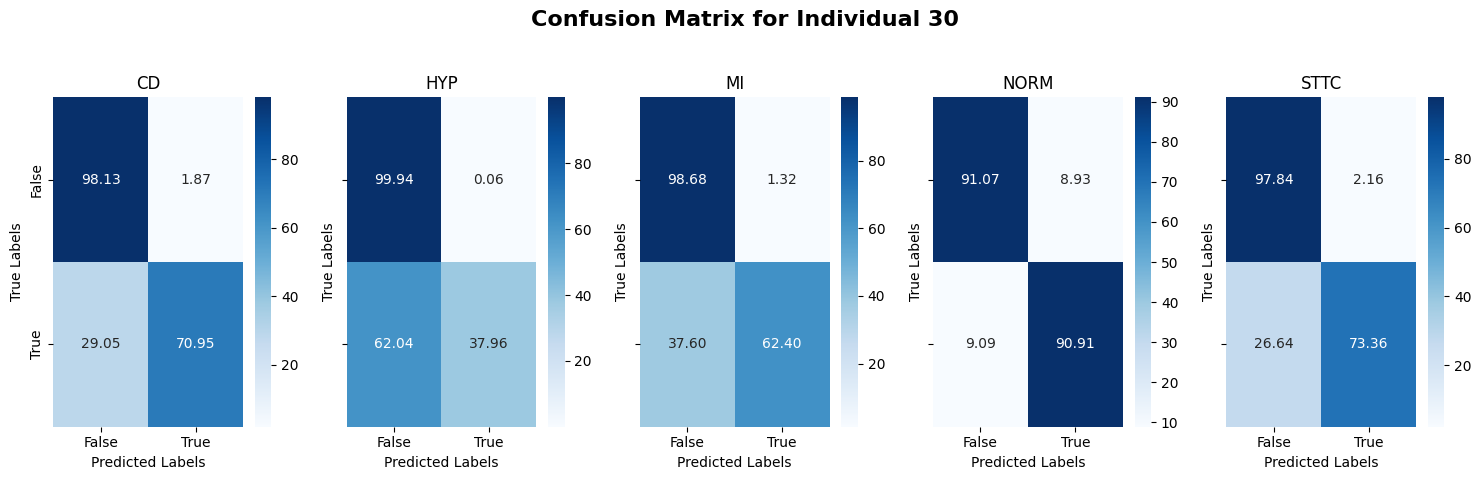

2024-04-16 07:09:27,139 - INFO - Calculating fitness for individual after 3 Phases 1/30


X_params shape: (1, 2)
n_estimators: 1066 max_depth: 10


2024-04-16 07:10:36,191 - INFO - Fitness for individual 1: 0.8428034901618957


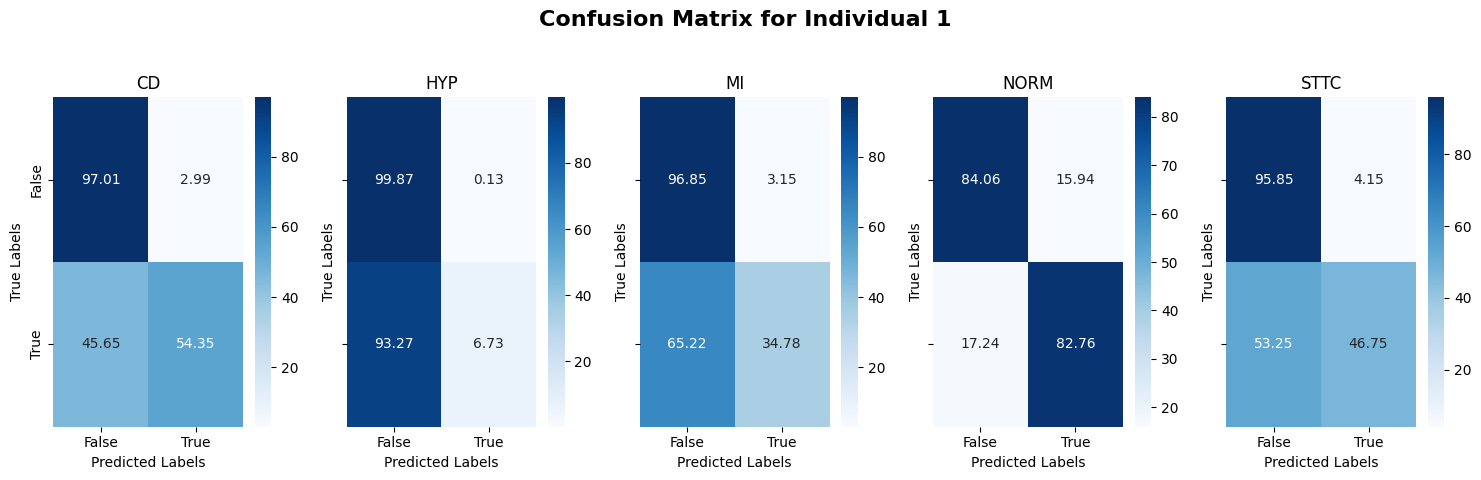

2024-04-16 07:10:38,430 - INFO - Calculating fitness for individual after 3 Phases 2/30


X_params shape: (1, 2)
n_estimators: 1374 max_depth: 61


2024-04-16 07:13:36,670 - INFO - Fitness for individual 2: 0.9099384427070618


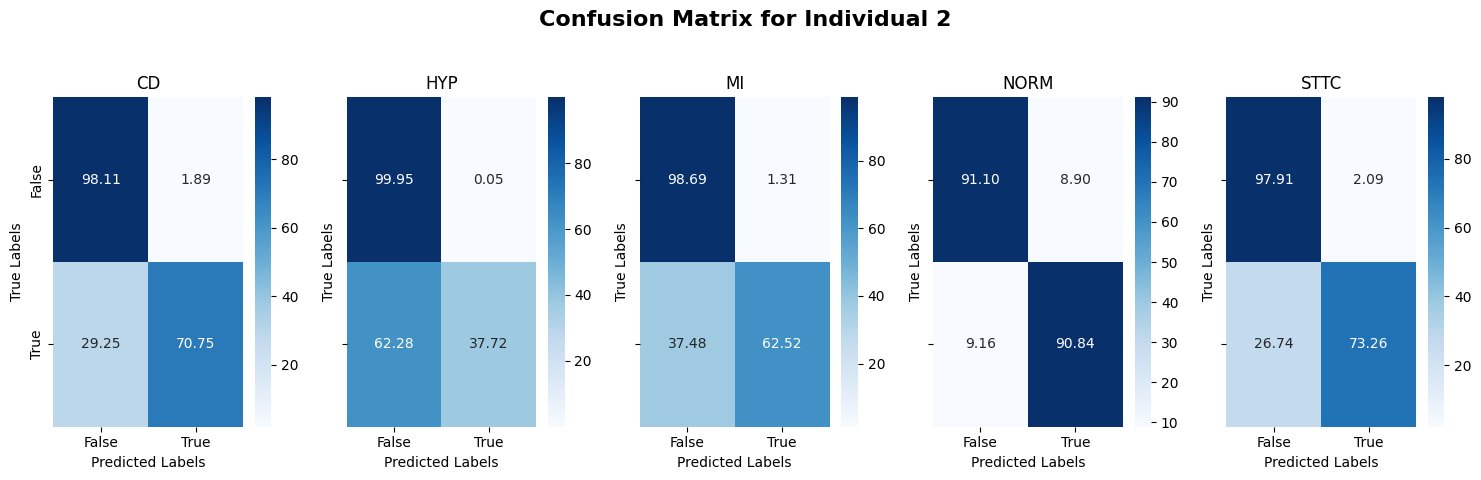

2024-04-16 07:13:38,596 - INFO - Calculating fitness for individual after 3 Phases 3/30


X_params shape: (1, 2)
n_estimators: 1334 max_depth: 17


2024-04-16 07:15:34,571 - INFO - Fitness for individual 3: 0.889371919631958


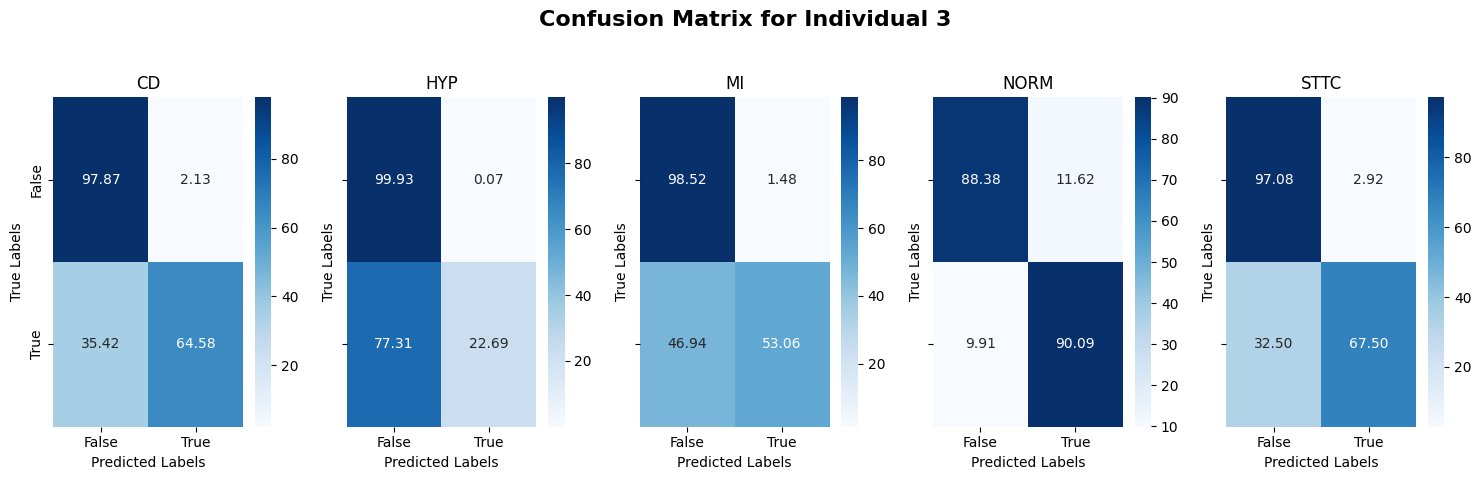

2024-04-16 07:15:36,458 - INFO - Calculating fitness for individual after 3 Phases 4/30


X_params shape: (1, 2)
n_estimators: 462 max_depth: 97


2024-04-16 07:16:34,756 - INFO - Fitness for individual 4: 0.909504234790802


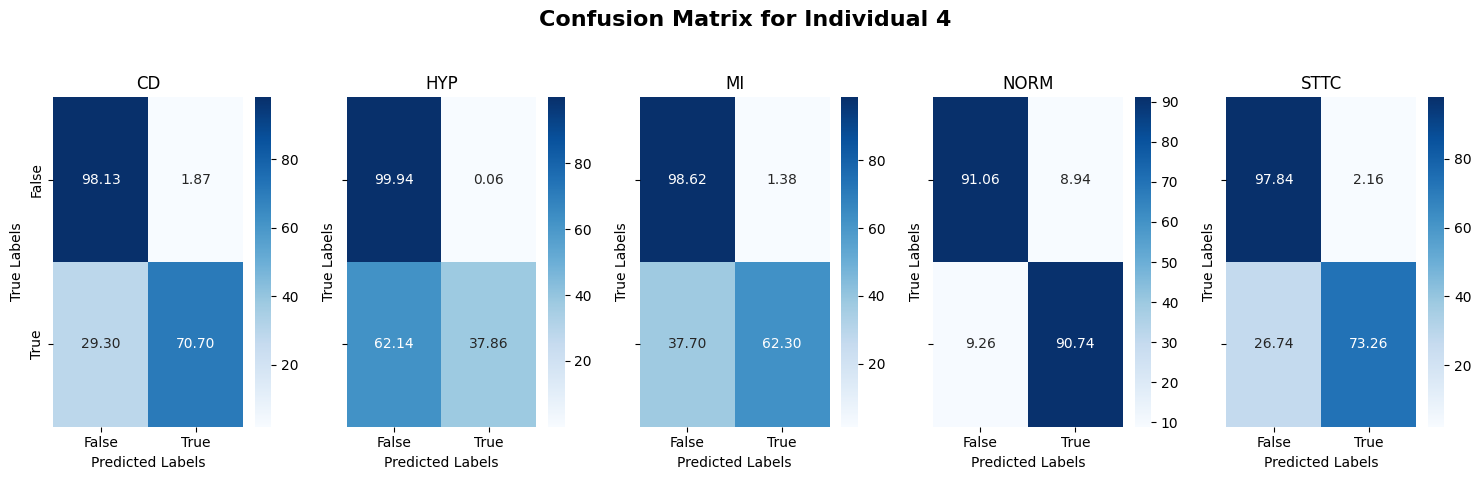

2024-04-16 07:16:36,615 - INFO - Calculating fitness for individual after 3 Phases 5/30


X_params shape: (1, 2)
n_estimators: 722 max_depth: 56


2024-04-16 07:18:09,314 - INFO - Fitness for individual 5: 0.9099997401237487


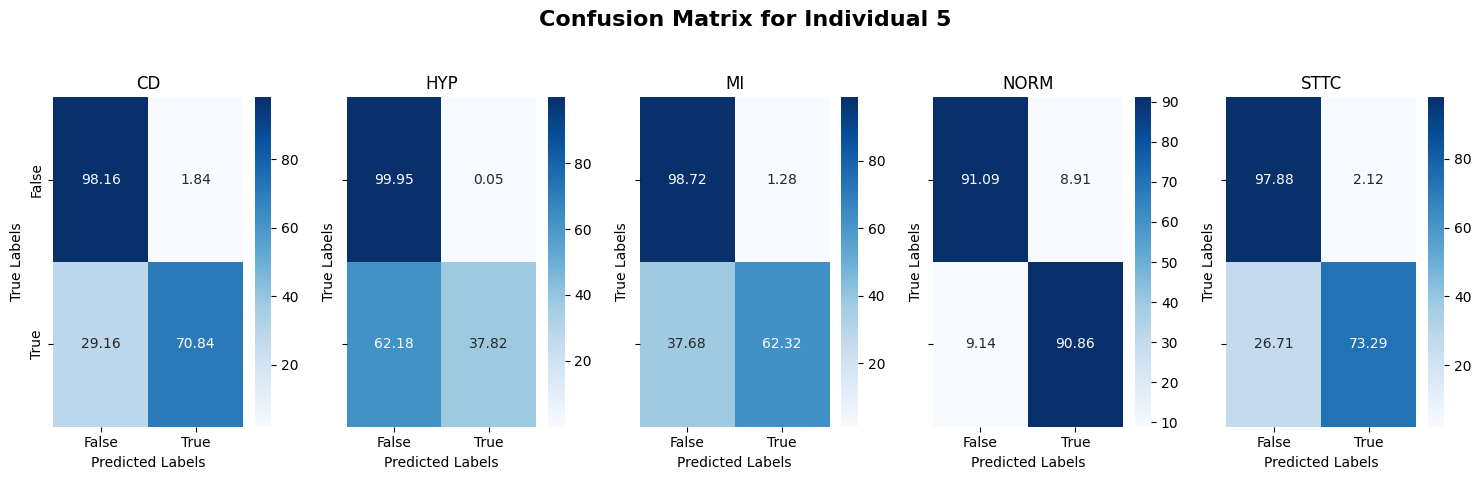

2024-04-16 07:18:11,183 - INFO - Calculating fitness for individual after 3 Phases 6/30


X_params shape: (1, 2)
n_estimators: 1346 max_depth: 57


2024-04-16 07:21:06,868 - INFO - Fitness for individual 6: 0.9099026679992676


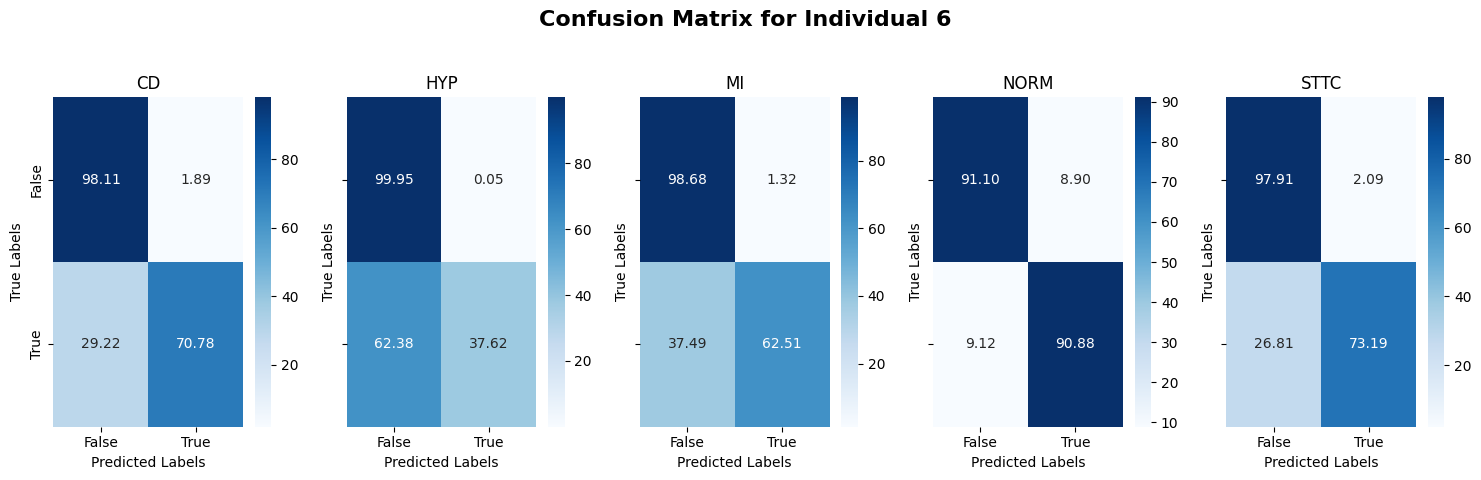

2024-04-16 07:21:09,158 - INFO - Calculating fitness for individual after 3 Phases 7/30


X_params shape: (1, 2)
n_estimators: 854 max_depth: 64


2024-04-16 07:22:55,994 - INFO - Fitness for individual 7: 0.9099077820777893


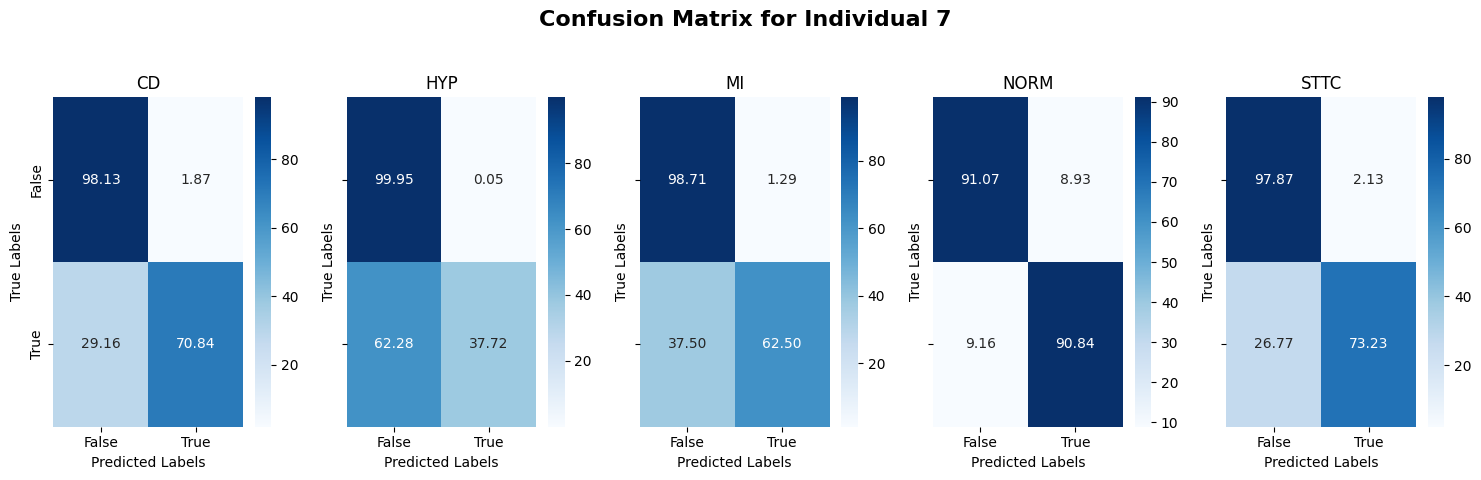

2024-04-16 07:22:57,961 - INFO - Calculating fitness for individual after 3 Phases 8/30


X_params shape: (1, 2)
n_estimators: 287 max_depth: 49


2024-04-16 07:23:36,923 - INFO - Fitness for individual 8: 0.909402048587799


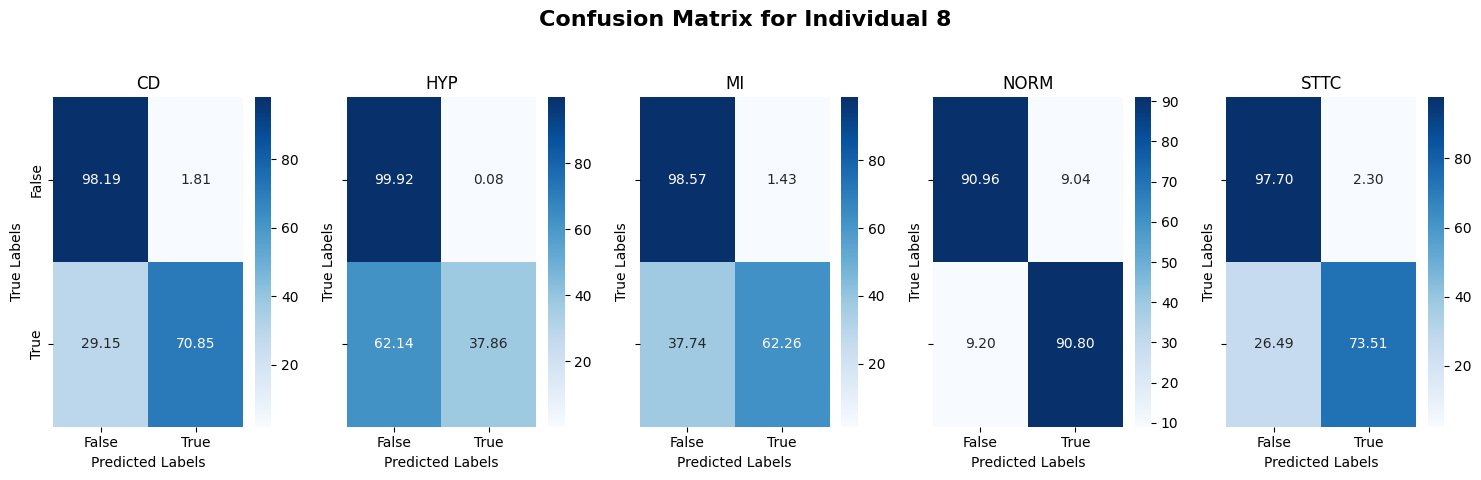

2024-04-16 07:23:38,825 - INFO - Calculating fitness for individual after 3 Phases 9/30


X_params shape: (1, 2)
n_estimators: 932 max_depth: 49


2024-04-16 07:25:46,271 - INFO - Fitness for individual 9: 0.909974193572998


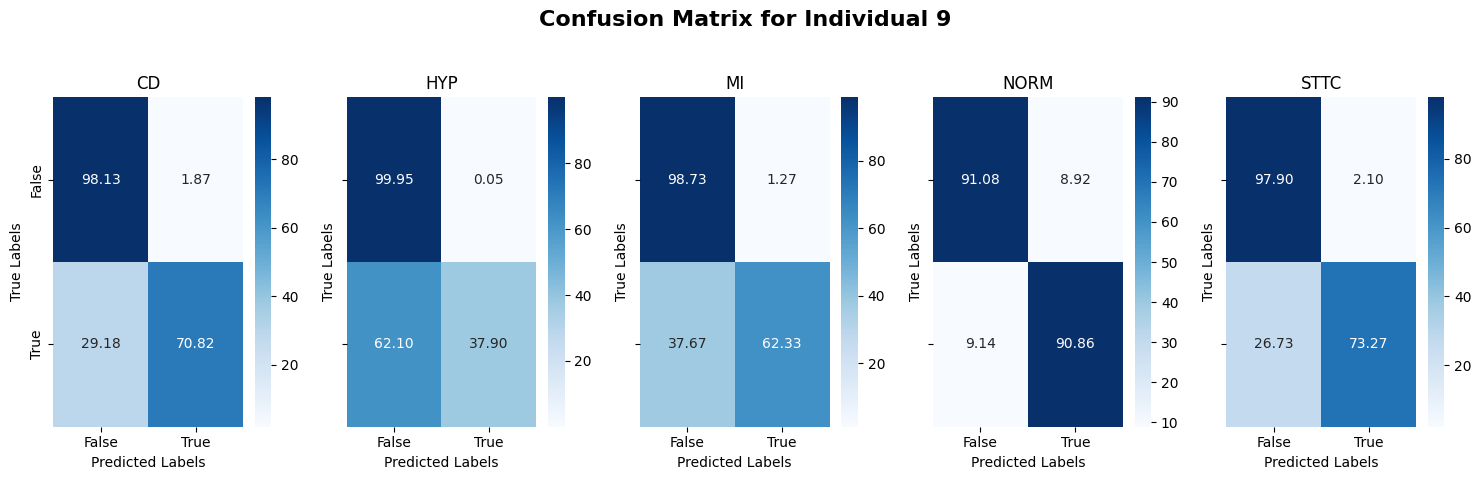

2024-04-16 07:25:48,153 - INFO - Calculating fitness for individual after 3 Phases 10/30


X_params shape: (1, 2)
n_estimators: 10 max_depth: 59


2024-04-16 07:25:51,484 - INFO - Fitness for individual 10: 0.8852340817451477


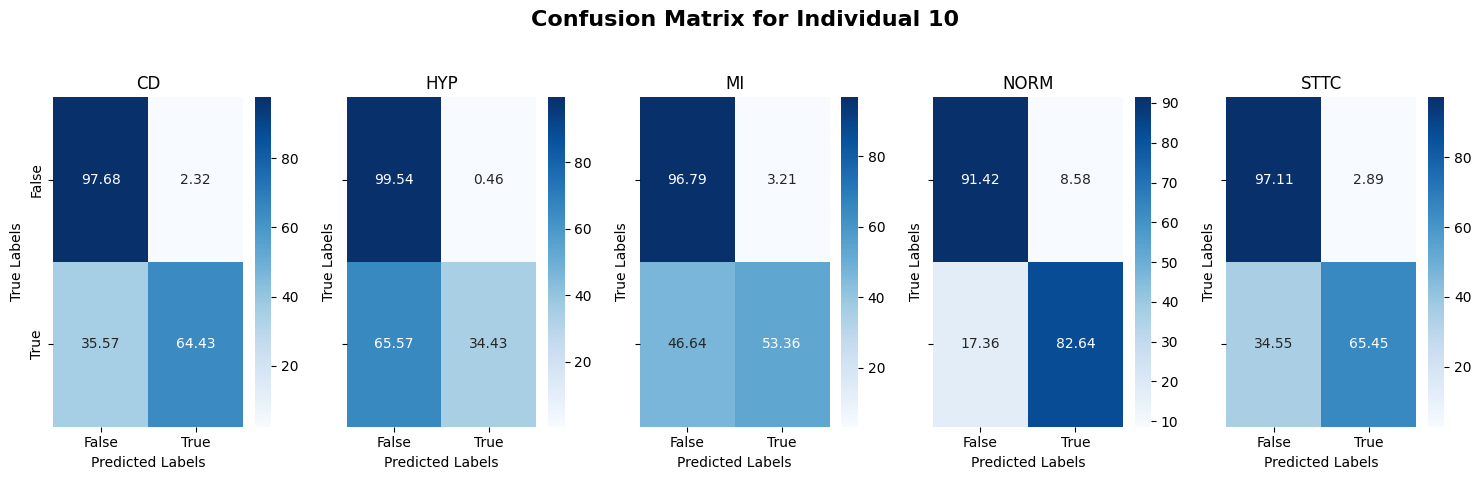

2024-04-16 07:25:53,335 - INFO - Calculating fitness for individual after 3 Phases 11/30


X_params shape: (1, 2)
n_estimators: 25 max_depth: 83


2024-04-16 07:25:58,300 - INFO - Fitness for individual 11: 0.9025210261344909


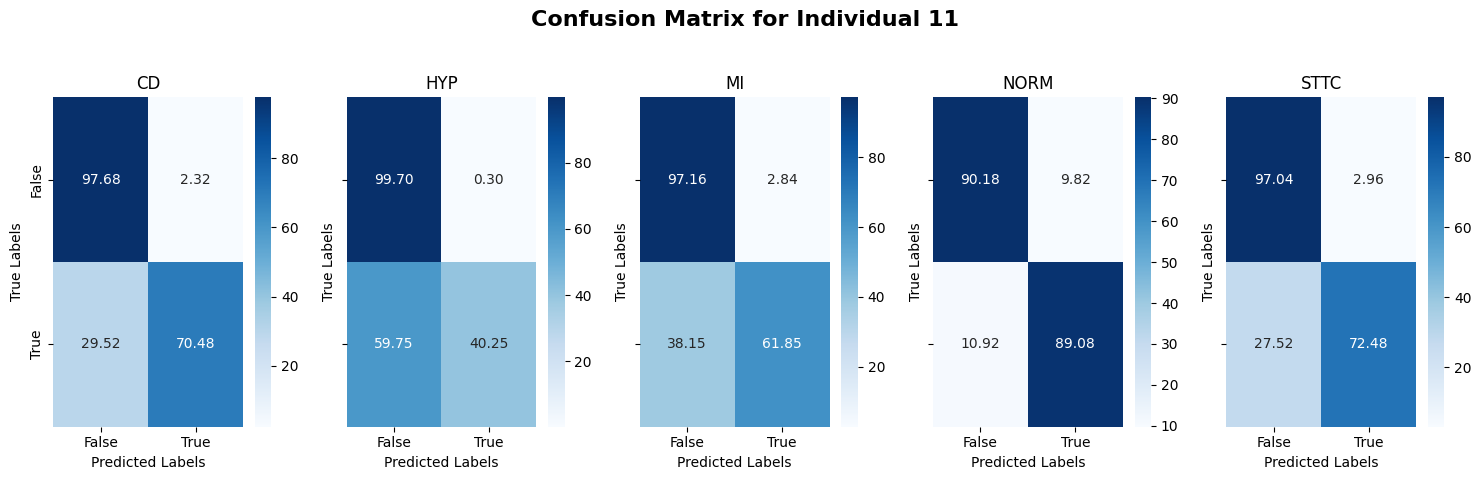

2024-04-16 07:26:00,155 - INFO - Calculating fitness for individual after 3 Phases 12/30


X_params shape: (1, 2)
n_estimators: 1976 max_depth: 63


2024-04-16 07:30:27,740 - INFO - Fitness for individual 12: 0.9100406050682068


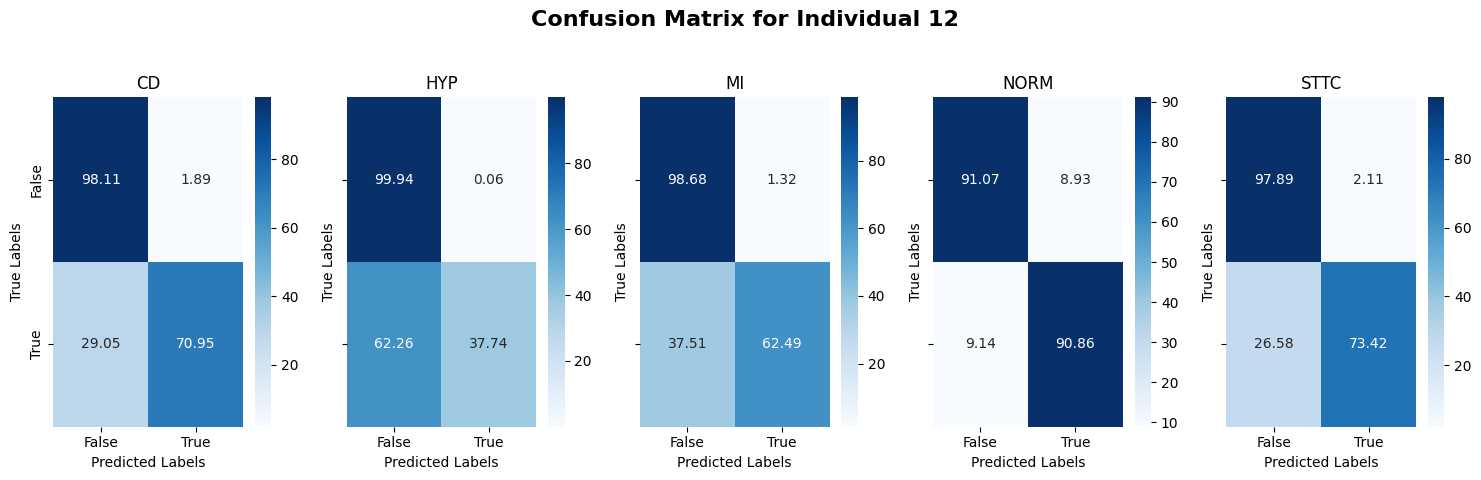

2024-04-16 07:30:29,757 - INFO - Calculating fitness for individual after 3 Phases 13/30


X_params shape: (1, 2)
n_estimators: 1207 max_depth: 75


2024-04-16 07:33:18,694 - INFO - Fitness for individual 13: 0.910117244720459


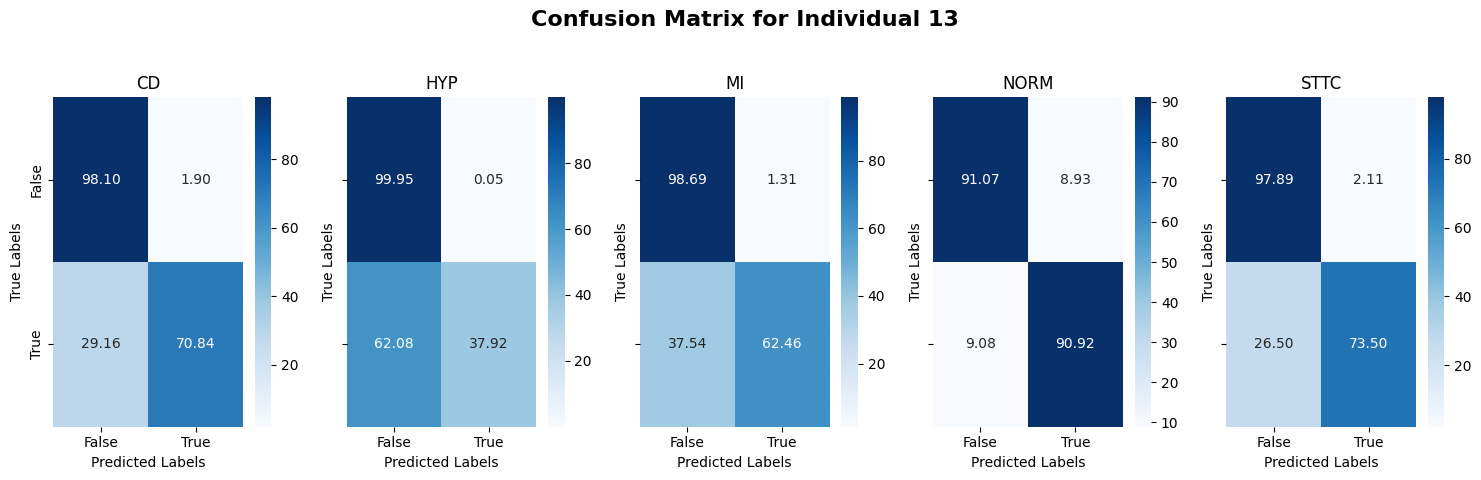

2024-04-16 07:33:20,651 - INFO - Calculating fitness for individual after 3 Phases 14/30


X_params shape: (1, 2)
n_estimators: 571 max_depth: 95


2024-04-16 07:34:36,526 - INFO - Fitness for individual 14: 0.9097136735916138


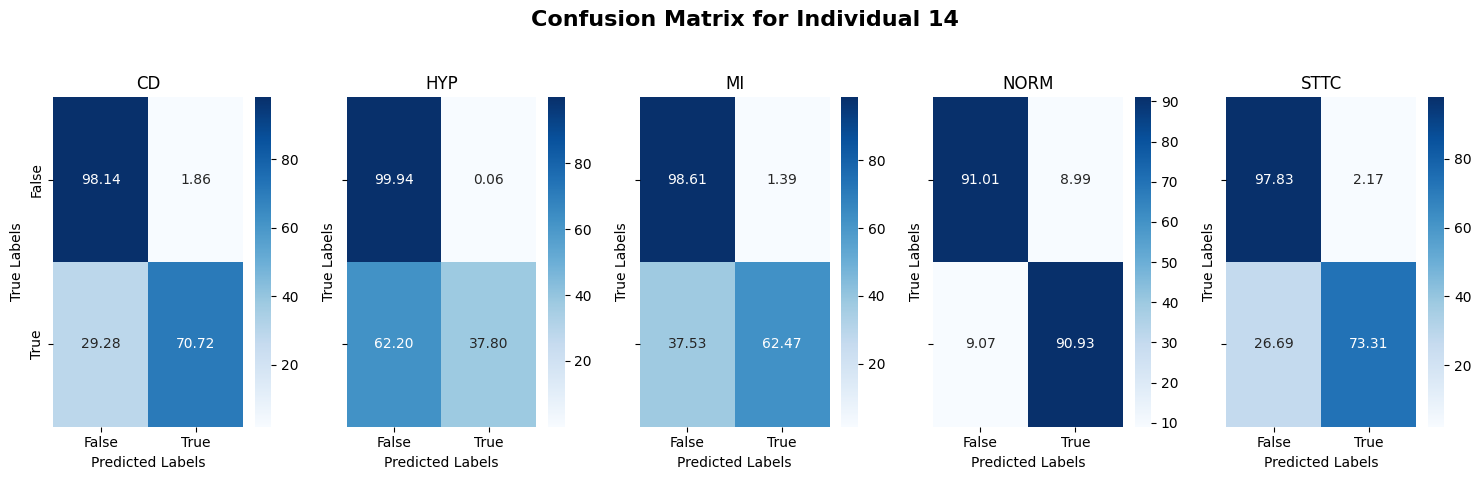

2024-04-16 07:34:38,403 - INFO - Calculating fitness for individual after 3 Phases 15/30


X_params shape: (1, 2)
n_estimators: 1374 max_depth: 56


2024-04-16 07:37:49,636 - INFO - Fitness for individual 15: 0.9099435567855835


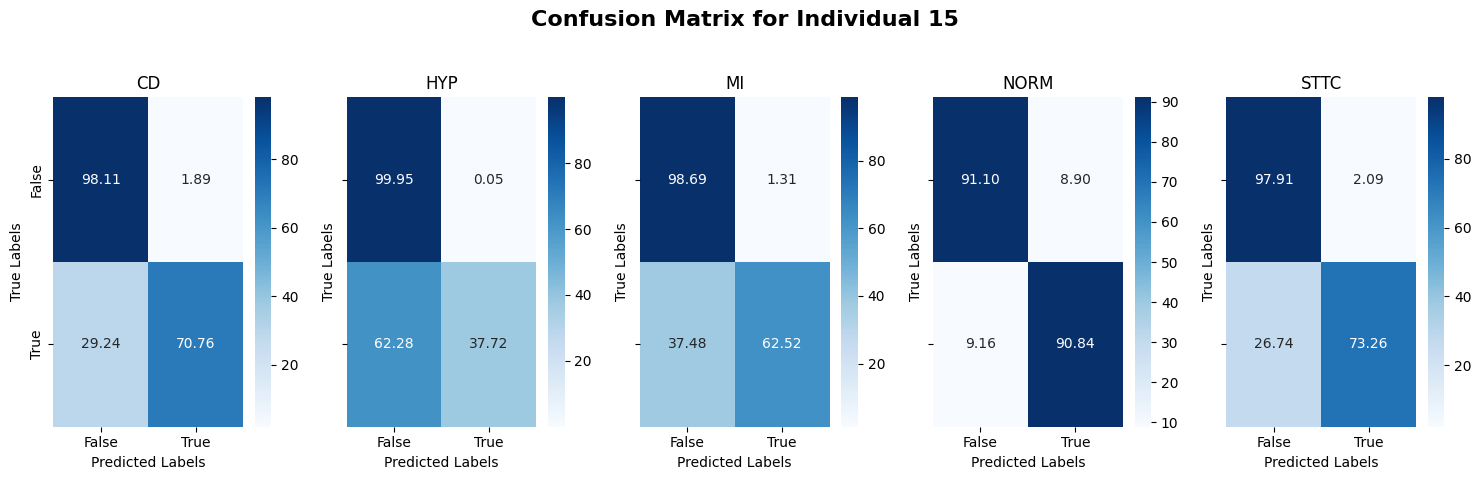

2024-04-16 07:37:51,911 - INFO - Calculating fitness for individual after 3 Phases 16/30


X_params shape: (1, 2)
n_estimators: 1505 max_depth: 65


2024-04-16 07:41:20,486 - INFO - Fitness for individual 16: 0.9100814938545227


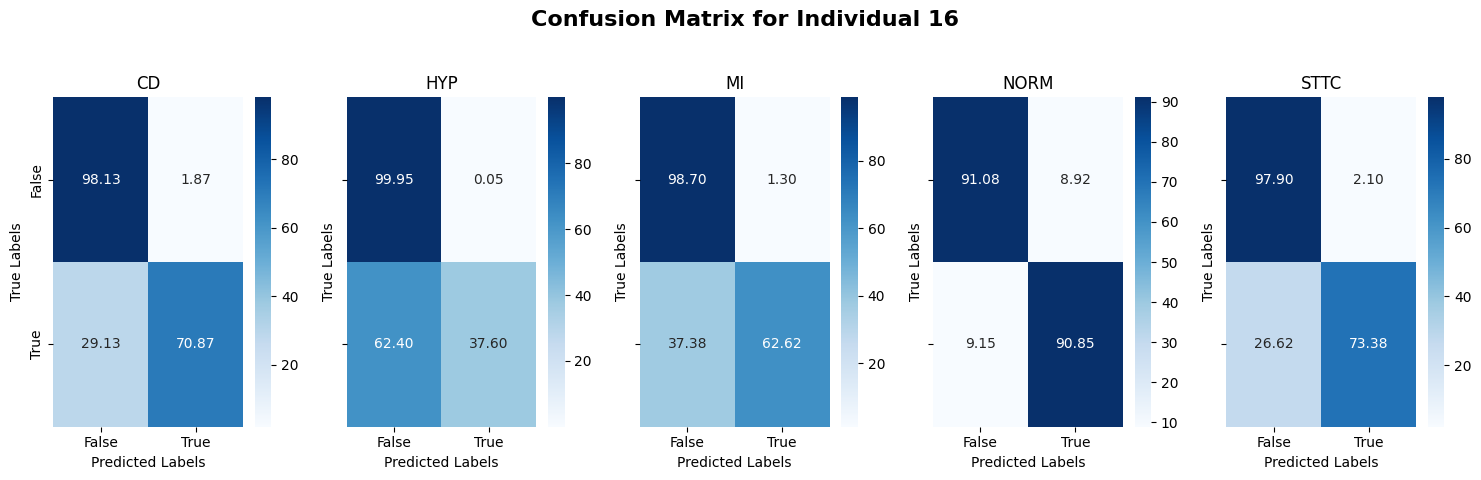

2024-04-16 07:41:22,755 - INFO - Calculating fitness for individual after 3 Phases 17/30


X_params shape: (1, 2)
n_estimators: 748 max_depth: 36


2024-04-16 07:43:02,964 - INFO - Fitness for individual 17: 0.909810733795166


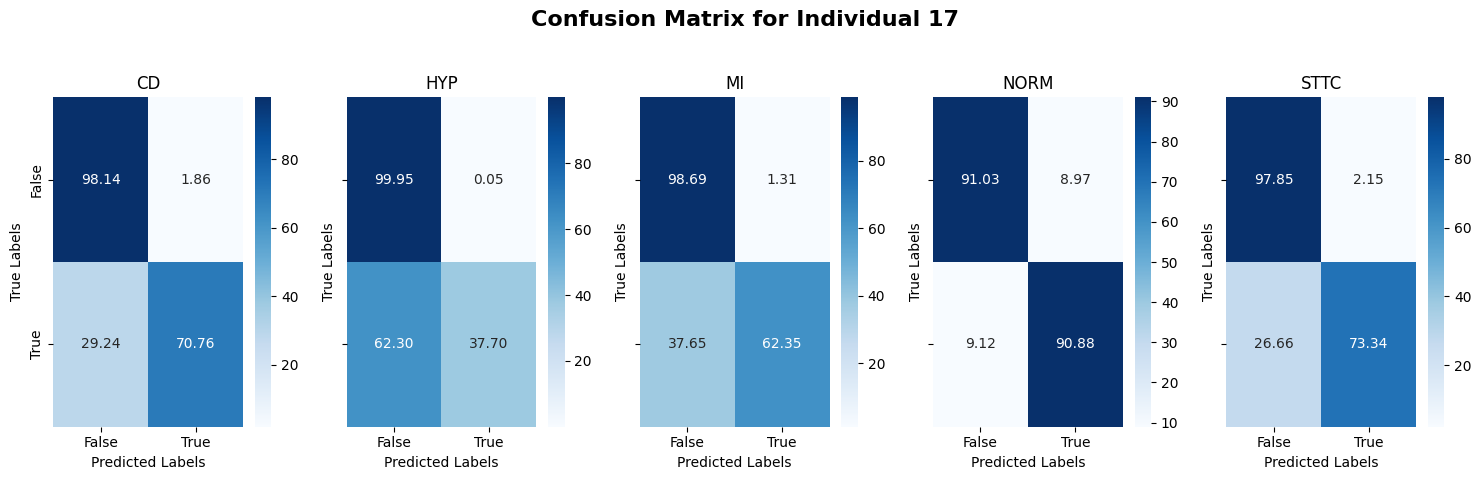

2024-04-16 07:43:04,866 - INFO - Calculating fitness for individual after 3 Phases 18/30


X_params shape: (1, 2)
n_estimators: 714 max_depth: 65


2024-04-16 07:44:43,663 - INFO - Fitness for individual 18: 0.9098975896835327


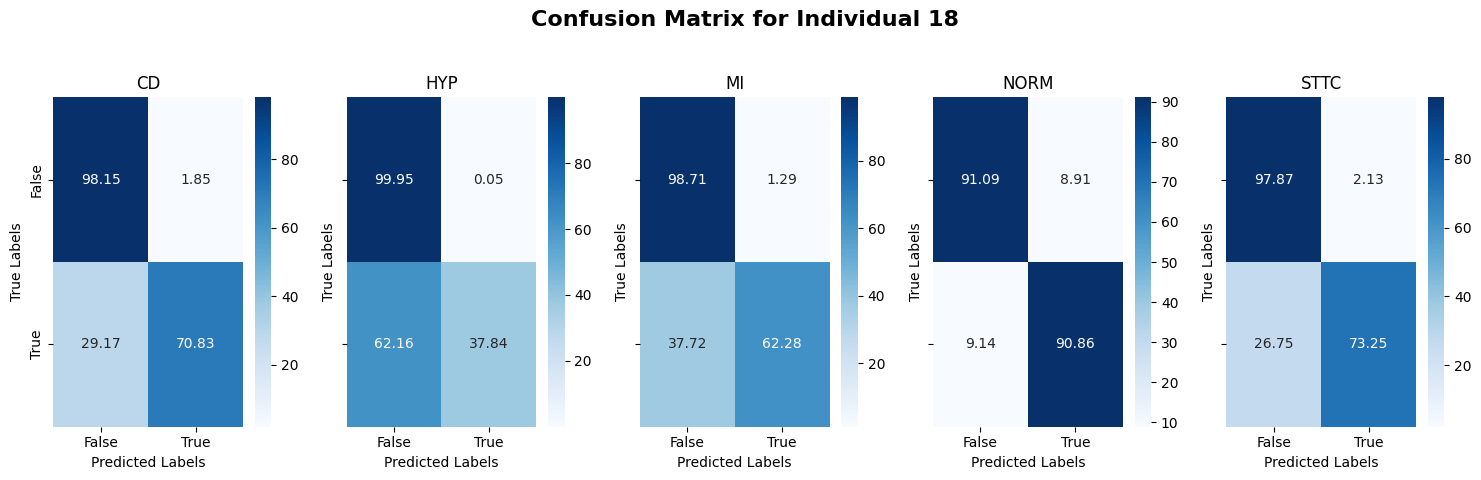

2024-04-16 07:44:45,550 - INFO - Calculating fitness for individual after 3 Phases 19/30


X_params shape: (1, 2)
n_estimators: 234 max_depth: 81


2024-04-16 07:45:19,114 - INFO - Fitness for individual 19: 0.9088554501533508


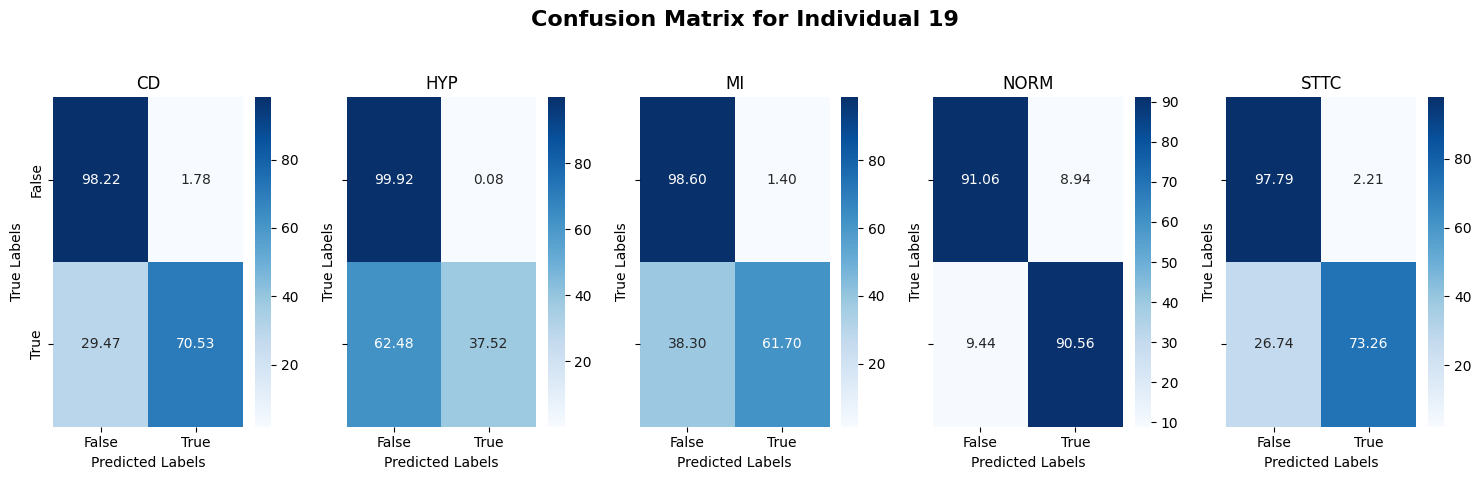

2024-04-16 07:45:21,022 - INFO - Calculating fitness for individual after 3 Phases 20/30


X_params shape: (1, 2)
n_estimators: 1266 max_depth: 42


2024-04-16 07:48:14,360 - INFO - Fitness for individual 20: 0.9100661396980285


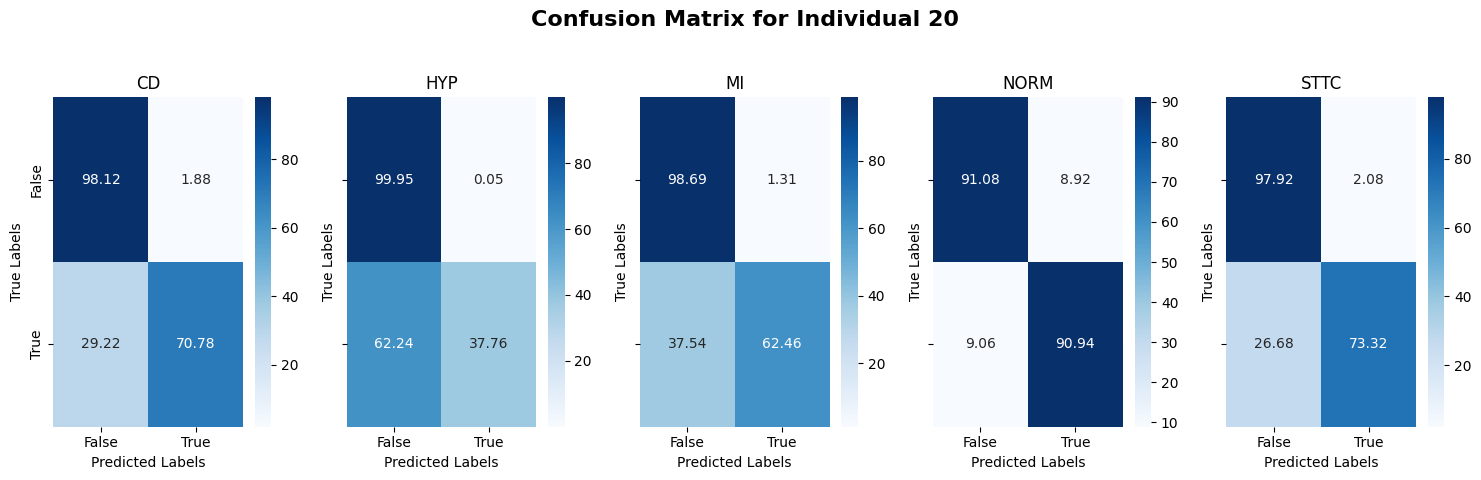

2024-04-16 07:48:16,242 - INFO - Calculating fitness for individual after 3 Phases 21/30


X_params shape: (1, 2)
n_estimators: 1386 max_depth: 83


2024-04-16 07:51:28,365 - INFO - Fitness for individual 21: 0.90993332862854


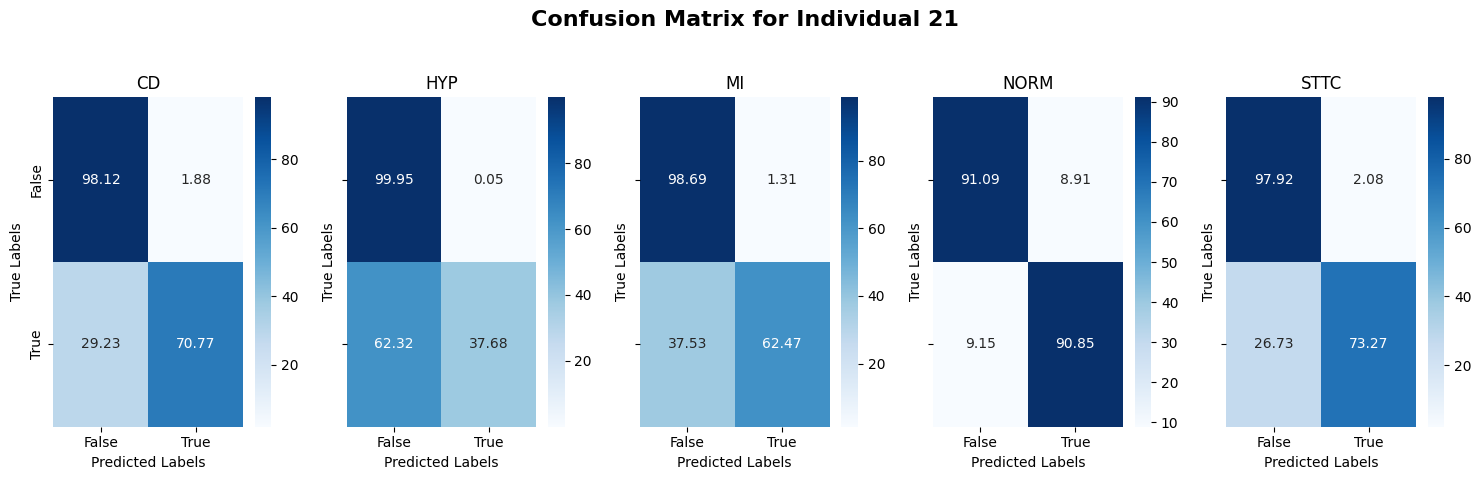

2024-04-16 07:51:30,546 - INFO - Calculating fitness for individual after 3 Phases 22/30


X_params shape: (1, 2)
n_estimators: 871 max_depth: 71


2024-04-16 07:53:31,310 - INFO - Fitness for individual 22: 0.910178542137146


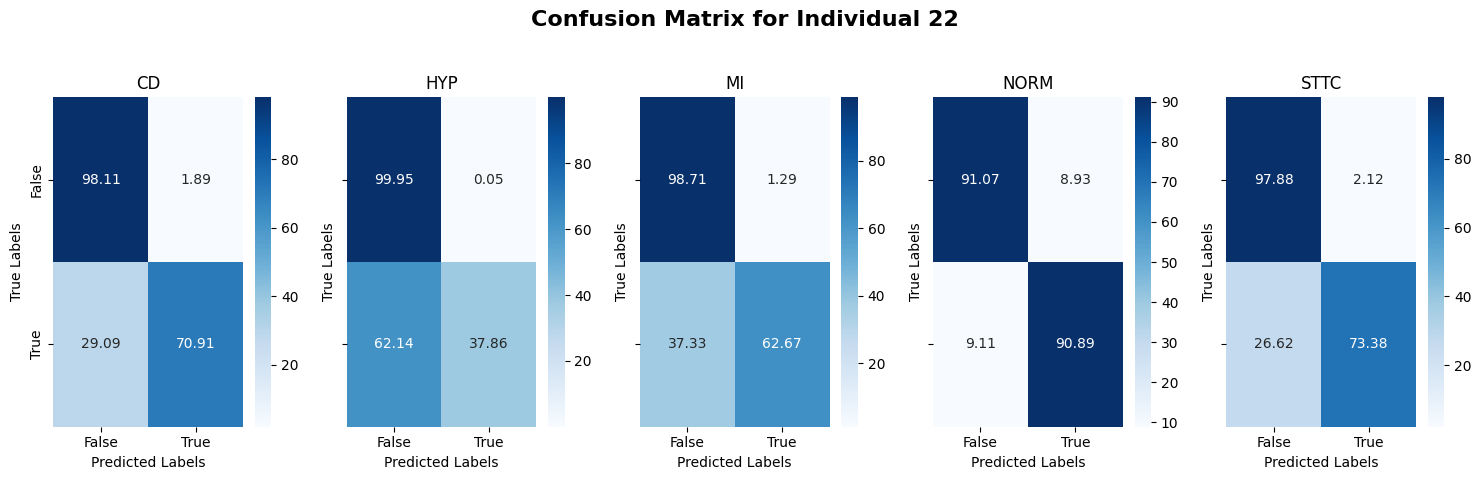

2024-04-16 07:53:33,269 - INFO - Calculating fitness for individual after 3 Phases 23/30


X_params shape: (1, 2)
n_estimators: 152 max_depth: 66


2024-04-16 07:53:56,240 - INFO - Fitness for individual 23: 0.9081913709640503


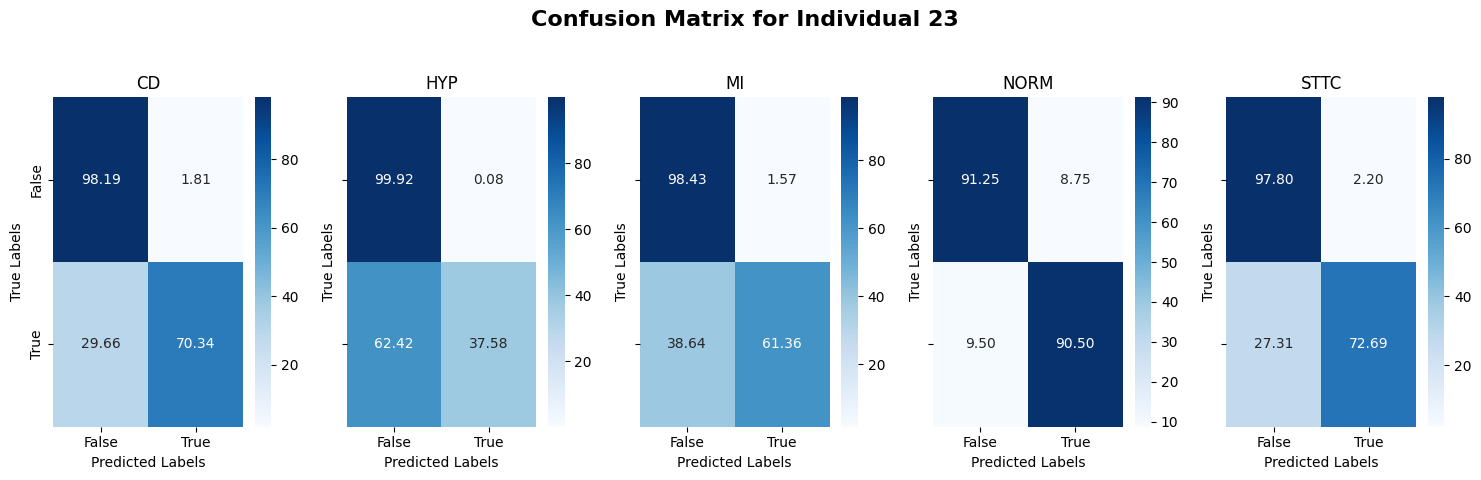

2024-04-16 07:53:58,105 - INFO - Calculating fitness for individual after 3 Phases 24/30


X_params shape: (1, 2)
n_estimators: 1466 max_depth: 81


2024-04-16 07:57:22,830 - INFO - Fitness for individual 24: 0.9100099563598633


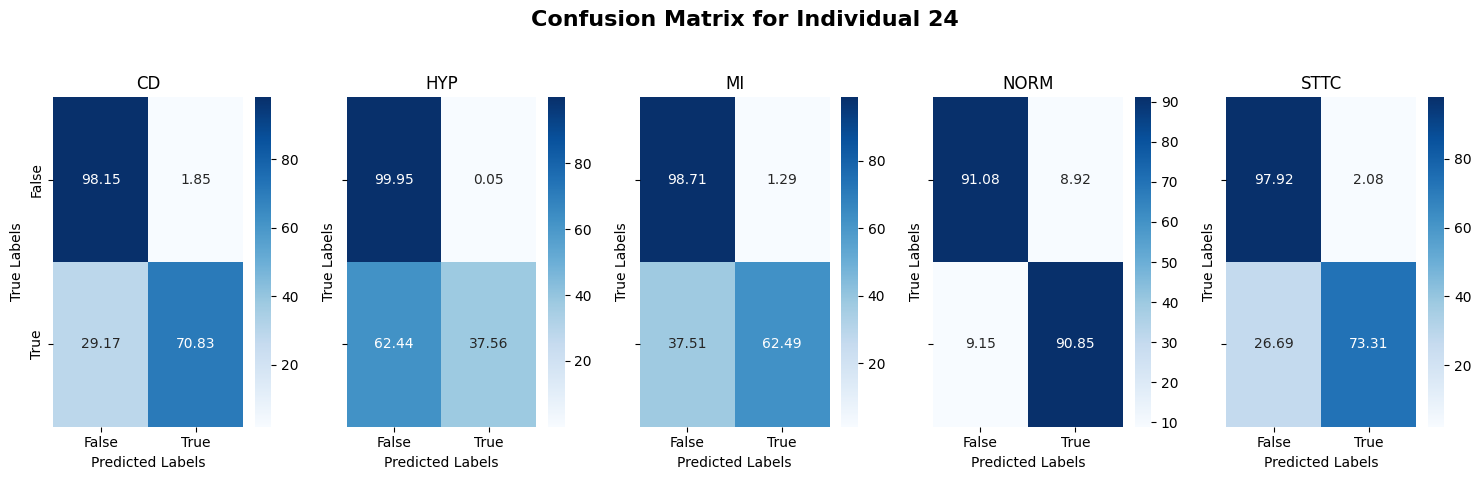

2024-04-16 07:57:24,694 - INFO - Calculating fitness for individual after 3 Phases 25/30


X_params shape: (1, 2)
n_estimators: 883 max_depth: 51


2024-04-16 07:59:27,582 - INFO - Fitness for individual 25: 0.9101478934288025


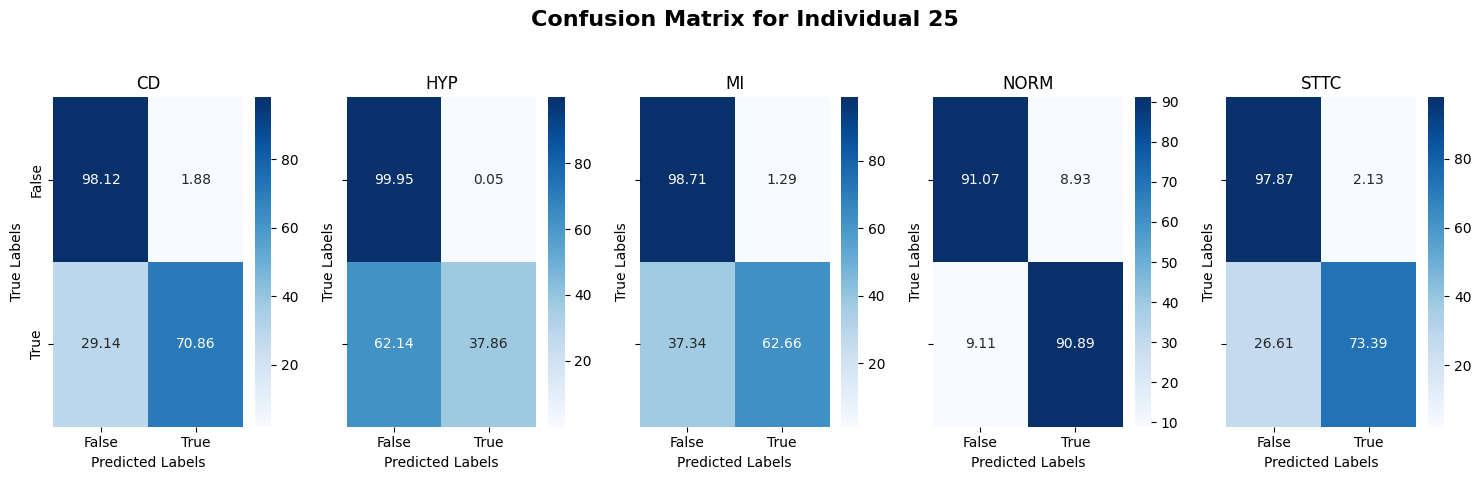

2024-04-16 07:59:29,456 - INFO - Calculating fitness for individual after 3 Phases 26/30


X_params shape: (1, 2)
n_estimators: 1310 max_depth: 73


2024-04-16 08:02:33,768 - INFO - Fitness for individual 26: 0.9100252866744996


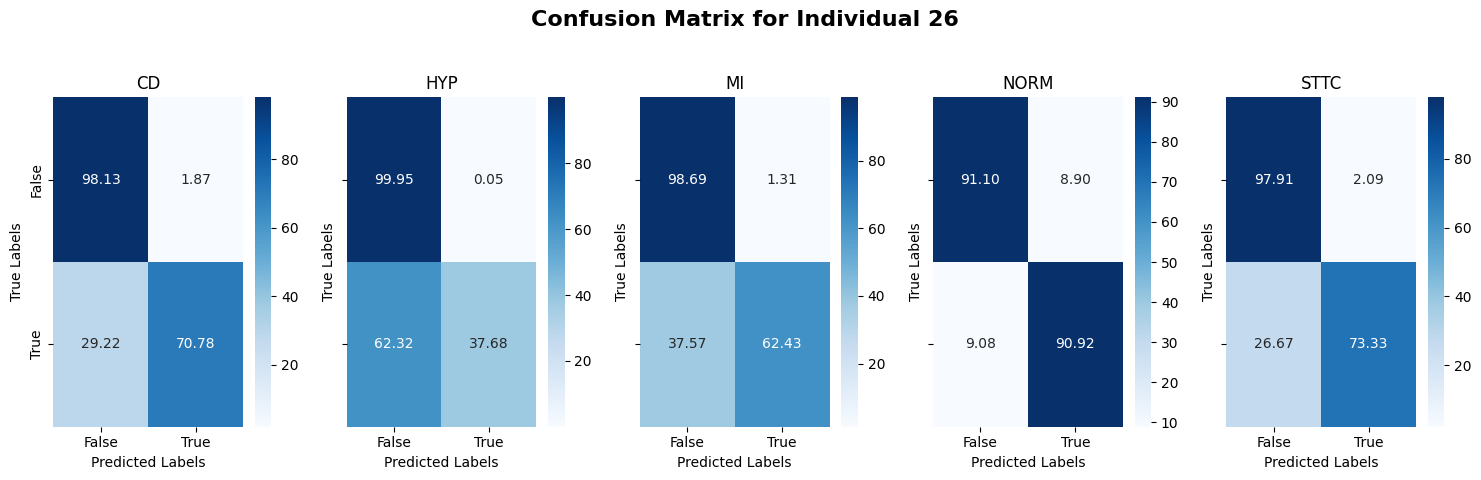

2024-04-16 08:02:35,670 - INFO - Calculating fitness for individual after 3 Phases 27/30


X_params shape: (1, 2)
n_estimators: 1867 max_depth: 86


2024-04-16 08:06:55,944 - INFO - Fitness for individual 27: 0.9099997520446778


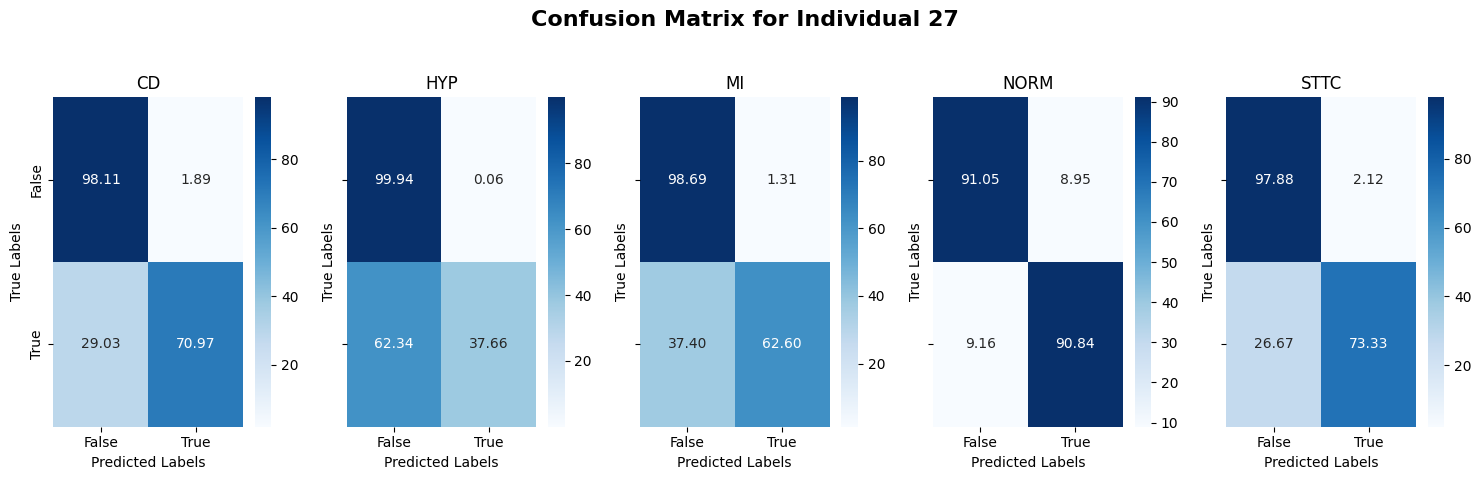

2024-04-16 08:06:57,846 - INFO - Calculating fitness for individual after 3 Phases 28/30


X_params shape: (1, 2)
n_estimators: 2000 max_depth: 72


2024-04-16 08:11:33,890 - INFO - Fitness for individual 28: 0.9100712537765503


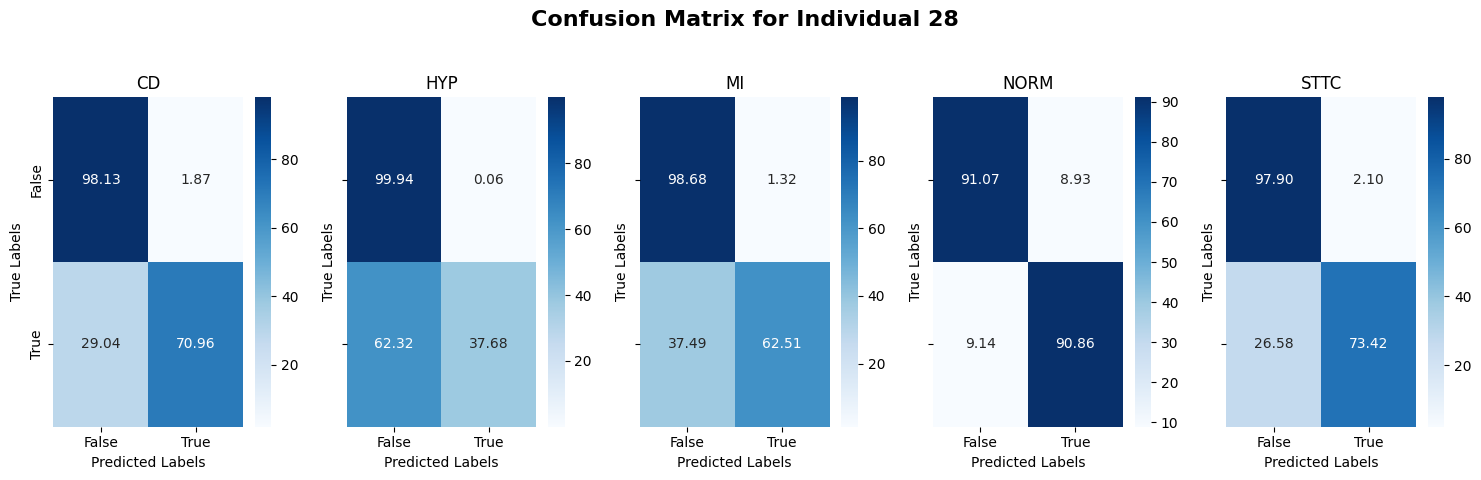

2024-04-16 08:11:35,784 - INFO - Calculating fitness for individual after 3 Phases 29/30


X_params shape: (1, 2)
n_estimators: 352 max_depth: 29


2024-04-16 08:12:21,080 - INFO - Fitness for individual 29: 0.908482551574707


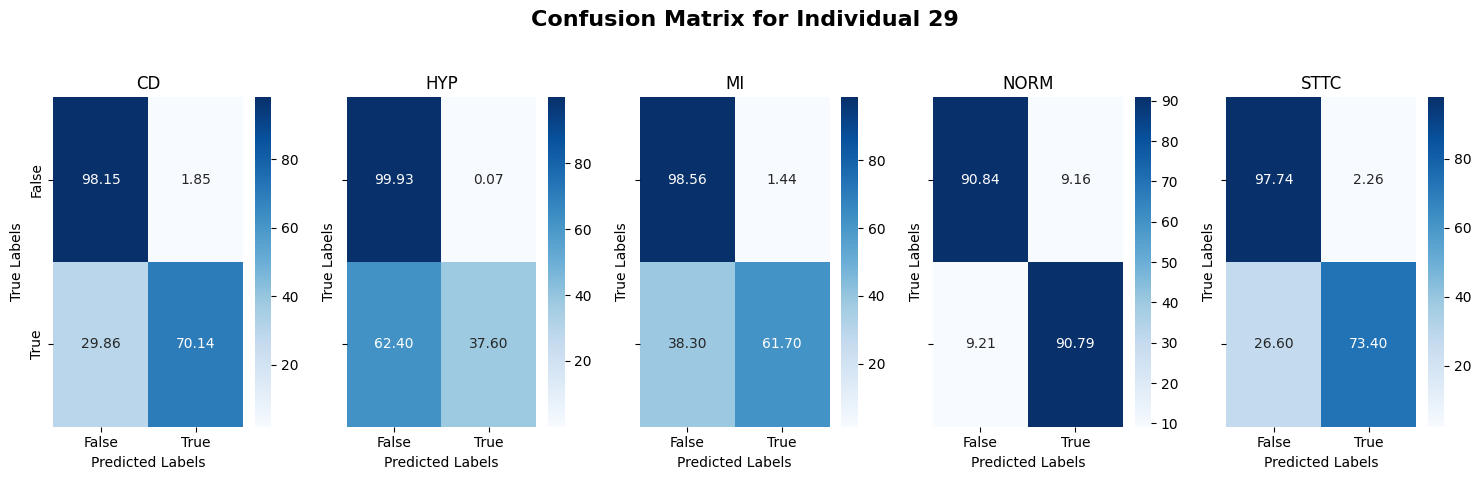

2024-04-16 08:12:23,000 - INFO - Calculating fitness for individual after 3 Phases 30/30


X_params shape: (1, 2)
n_estimators: 727 max_depth: 64


2024-04-16 08:14:03,056 - INFO - Fitness for individual 30: 0.9100610375404358


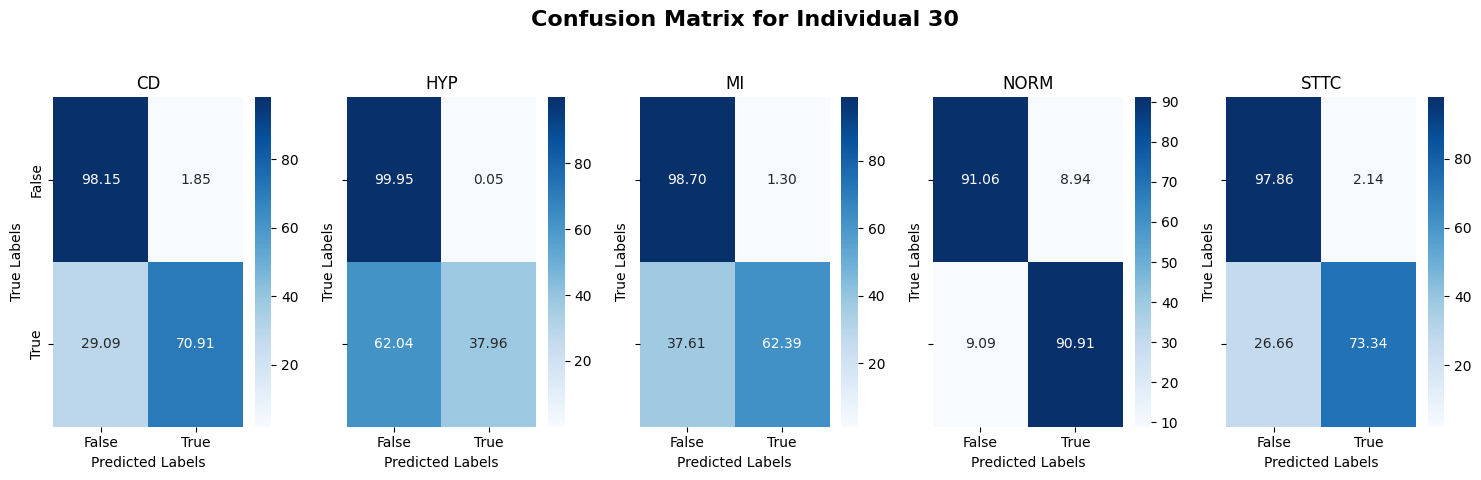

2024-04-16 08:14:04,926 - INFO - Iteration: 1/20, Best Fitness: 0.910178542137146, Average Fitness: 0.9058062362670899
2024-04-16 08:14:04,927 - INFO - Fitness threshold reached: 0.910178542137146 at iteration 1. Terminating...
2024-04-16 08:14:04,929 - INFO - Model saved to best_model_mpa_RF_ptb_xl.pkl with fitness 0.910178542137146 at iteration 1
2024-04-16 08:14:04,930 - INFO - Finished MPA_RF optimization for PTB-XL dataset. Total duration: 138.21 minutes.
2024-04-16 08:14:04,932 - INFO - Top predator position (rounded to integers): [871, 71]
2024-04-16 08:14:04,933 - INFO - Top predator fitness: 0.910178542137146


Top predator position (rounded to integers): [871, 71]
Top predator fitness: 0.910178542137146


In [13]:
import time

def run_mpa_for_all_labels(X_train, X_val, y_train, y_val, search_agents_no, Max_iter, lb, ub, dim, rf_accuracy_fitness, fitness_threshold=0.90):
    """
    Runs MPA optimization for all labels and plots the convergence curve for each label.

    Parameters:
    - X_train, X_val, y_train, y_val: Training and validation sets.
    - search_agents_no: Number of search agents.
    - Max_iter: Maximum number of iterations.
    - lb, ub: Lower and upper bounds for optimization parameters.
    - dim: Number of dimensions/hyperparameters.
    - rf_accuracy_fitness: Fitness function for the Random Forest model.
    - fitness_threshold: Threshold for stopping the optimization.
    """
    overall_start_time = time.time()

    # Example usage with correctly structured return values for MPA
    results = {}  # Assuming MPA should populate this dictionary
    
    # Example call to MPA for one label (extend as needed for multiple labels)
    top_predator_pos, top_predator_fit = MPA(
        search_agents_no, Max_iter, lb, ub, dim, 
        X_train, y_train, X_val, y_val, 
        rf_accuracy_fitness, fitness_threshold
    )
    
    # Rounding top predator position to nearest integers for logging and usage
    rounded_top_predator_pos = [round(pos) for pos in top_predator_pos]

    # Populate the results dictionary with mock label data (extend as needed)
    results['MockLabel'] = {
        'Top_predator_pos': rounded_top_predator_pos,
        'Top_predator_fitness': top_predator_fit
    }

    overall_end_time = time.time()
    total_duration_minutes = (overall_end_time - overall_start_time) / 60

    # Get the top predator position and fitness from the 'results' dictionary for the mock label
    top_predator_pos = results['MockLabel']['Top_predator_pos']
    top_predator_fit = results['MockLabel']['Top_predator_fitness']
    
    # Log the top predator fitness and position
    logging.info(f"Finished MPA_RF optimization for PTB-XL dataset. Total duration: {total_duration_minutes:.2f} minutes.")
    logging.info(f"Top predator position (rounded to integers): {top_predator_pos}")
    logging.info(f"Top predator fitness: {top_predator_fit}")
    
    # Optionally, print them out to the console as well
    print(f"Top predator position (rounded to integers): {top_predator_pos}")
    print(f"Top predator fitness: {top_predator_fit}")


run_mpa_for_all_labels(X_train, X_val, y_train, y_val, search_agents_no, Max_iter, lb, ub, dim, rf_accuracy_fitness, fitness_threshold=0.90)


### Evaluating on Test Dataset

In [14]:
import cudf
# Example loading test data (adjust path and processing as needed)
test_data = cudf.read_csv('/home/jupyter-yangiev/MPA_int_ML/Test_new.csv')

features = [str(i) for i in range(187)] + [f'coeff{i}' for i in range(1, 221)] + ['SDNN', 'RMSSD', 'Mean_P_Wave_Duration', 'Mean_QRS_Duration', 'Mean_T_Wave_Duration', 'Mean_QT_Interval', 'Mean_PR_Interval']
labels = ['CD', 'HYP', 'MI', 'NORM', 'STTC']

X_test = test_data[features].astype('float32')
y_test = test_data[labels].astype('int32')  # Adjust label column as per your dataset


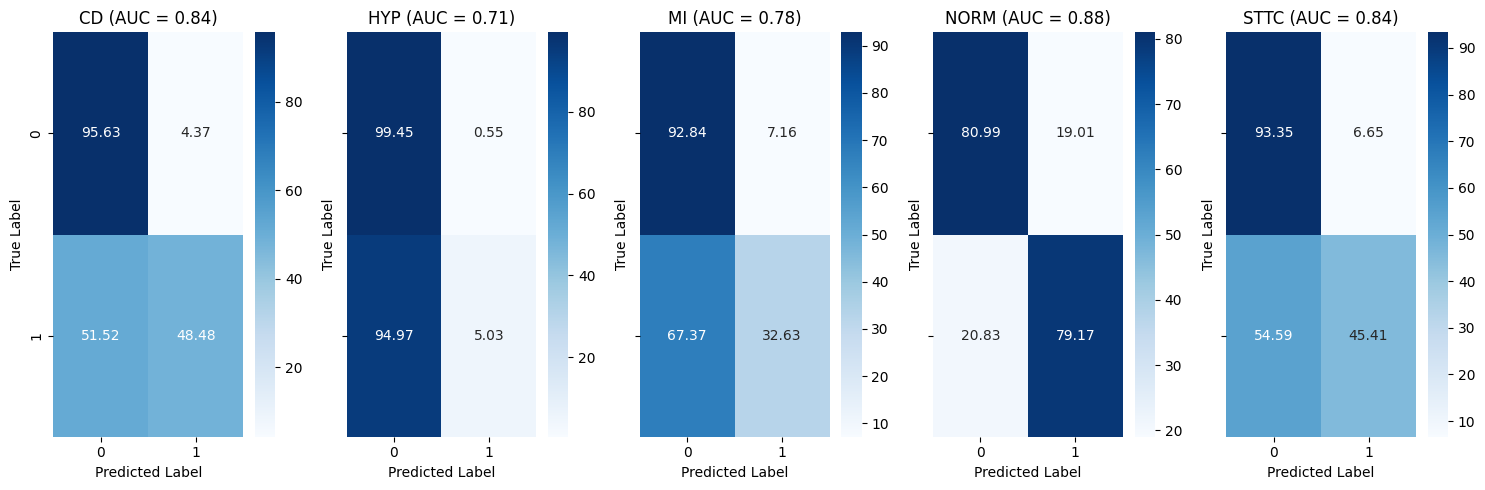

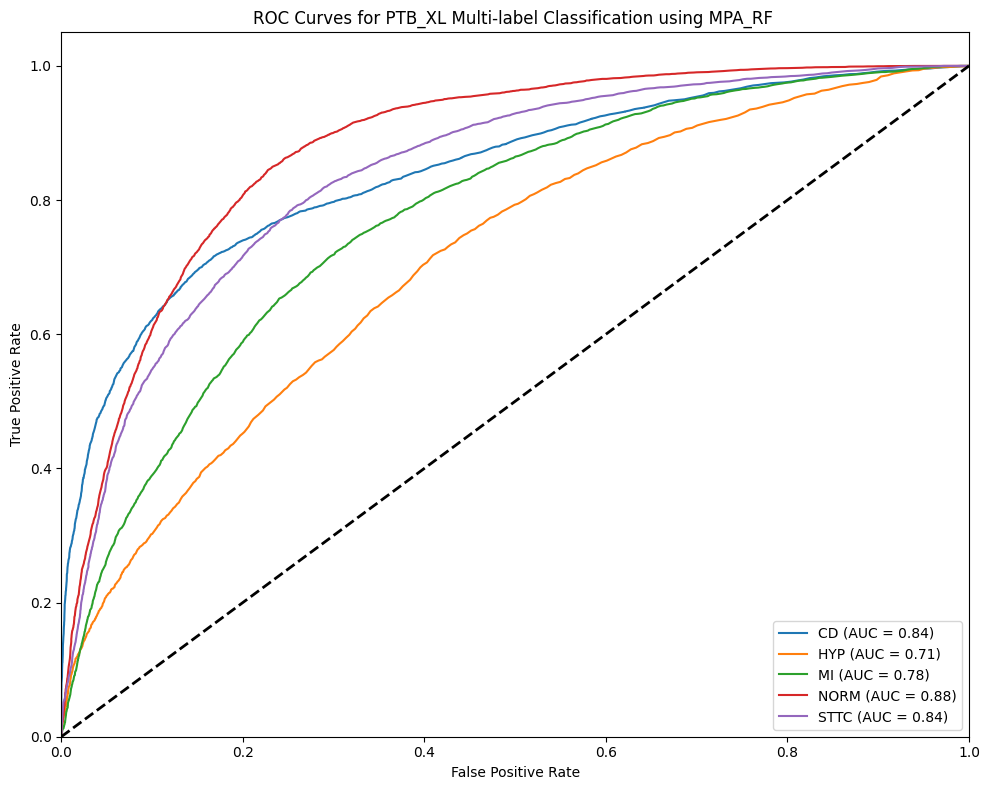

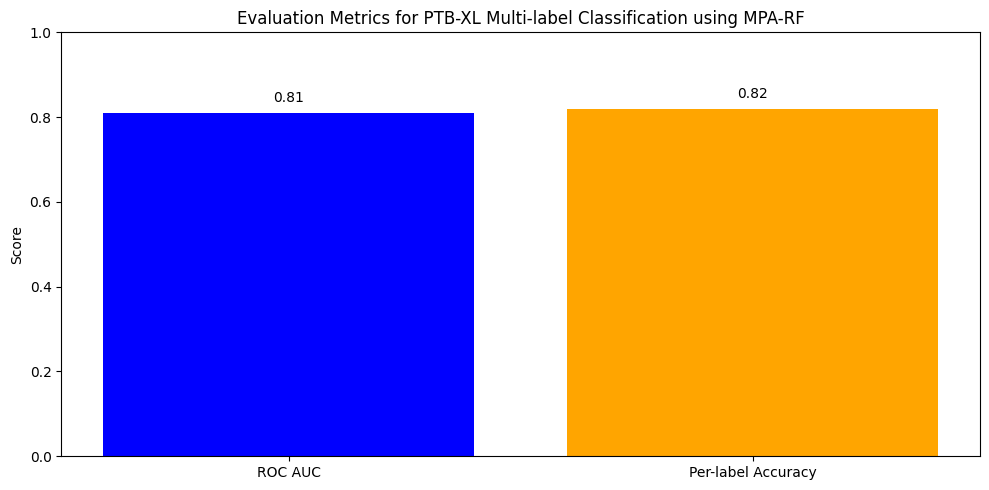

Classification Report for CD:
              precision    recall  f1-score   support

           0       0.86      0.96      0.90     16785
           1       0.78      0.48      0.60      5280

    accuracy                           0.84     22065
   macro avg       0.82      0.72      0.75     22065
weighted avg       0.84      0.84      0.83     22065

Classification Report for HYP:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     19283
           1       0.57      0.05      0.09      2782

    accuracy                           0.88     22065
   macro avg       0.72      0.52      0.51     22065
weighted avg       0.84      0.88      0.83     22065

Classification Report for MI:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85     16079
           1       0.63      0.33      0.43      5986

    accuracy                           0.77     22065
   macro avg       0.71      0.63    

In [15]:
import cudf
import cupy as cp
from cuml.ensemble import RandomForestClassifier as cumlRF
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from cuml import set_global_output_type
import numpy as np

# Set global output type to cupy for cuML compatibility with cuPy
set_global_output_type('cupy')

# Load the best model saved from MPA
with open('best_model_mpa_RF_ptb_xl.pkl', 'rb') as f:
    model = pickle.load(f)

# Prepare to store predictions and probabilities
y_probs = {}
y_preds = {}
roc_aucs = []
accuracies = []

# Plot confusion matrices
num_labels = len(labels)
# Plot confusion matrices
fig_cm, axes_cm = plt.subplots(1, num_labels, figsize=(15, 5), sharey=True)  # Create a new figure for confusion matrices

for idx, label in enumerate(labels):
    model.fit(X_train, y_train[label])
    # Predict probabilities and labels
    y_probs[label] = model.predict_proba(X_test)[:, 1]
    y_preds[label] = model.predict(X_test)
    
    # Convert to NumPy arrays for calculation
    y_true_np = y_test[label].to_numpy()
    y_score_np = cp.asnumpy(y_probs[label])

    # Calculate and plot ROC curve
    fpr, tpr, _ = roc_curve(y_true_np, y_score_np)
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)
    # Calculate accuracy
    accuracy = np.mean(y_preds[label].get() == y_true_np)
    accuracies.append(accuracy)
    
    # Calculate and plot confusion matrix
    cm = confusion_matrix(y_true_np, y_preds[label].get())
    cm_percentage = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', ax=axes_cm[idx])
    axes_cm[idx].set_title(f'{label} (AUC = {roc_auc:.2f})')
    axes_cm[idx].set_xlabel('Predicted Label')
    axes_cm[idx].set_ylabel('True Label')

plt.tight_layout()
plt.savefig('confusion_matrices_mpa_RF_ptb_xl.png', dpi=300)  # Save confusion matrices as high-res PNG
plt.show()

# Now plot ROC curves
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))  # Create a new figure for ROC curves

for idx, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[label].to_numpy(), cp.asnumpy(y_probs[label]))
    roc_auc = roc_aucs[idx]
    ax_roc.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

ax_roc.plot([0, 1], [0, 1], 'k--', lw=2)
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curves for PTB_XL Multi-label Classification using MPA_RF ')
ax_roc.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve_mpa_RF_ptb_xl.png', format='png', dpi=300)  # Save ROC curves as high-res PNG
plt.show()

# Plot ROC-AUC and Accuracy in a bar chart
plt.figure(figsize=(10, 5))
metrics = ['ROC AUC', 'Per-label Accuracy']
scores = [np.mean(roc_aucs), np.mean(accuracies)]
plt.bar(metrics, scores, color=['blue', 'orange'])
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')
plt.title('Evaluation Metrics for PTB-XL Multi-label Classification using MPA-RF')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('evaluation_metrics_mpa_RF_ptb_xl.png', dpi=300)
plt.show()

# Print classification report for each label
for label in labels:
    print(f'Classification Report for {label}:')
    print(classification_report(y_test[label].to_numpy(), y_preds[label].get()))

